In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [3]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
#     weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.02)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
#             if i * ncol + j in restrained_patches and method != 'unbiased':
#                 for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
#                     pf(ax[i,j],0, color='C3')
#                 ax[i,j].spines['bottom'].set_color('y')
#                 ax[i,j].spines['top'].set_color('y') 
#                 ax[i,j].spines['right'].set_color('y')
#                 ax[i,j].spines['left'].set_color('y')
#                 ax[i,j].spines['left'].set_linewidth(2)
#                 ax[i,j].spines['top'].set_linewidth(2)
#                 ax[i,j].spines['right'].set_linewidth(2)
#                 ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


## Reference Model

In [5]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
population_fraction = population/np.sum(population)
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


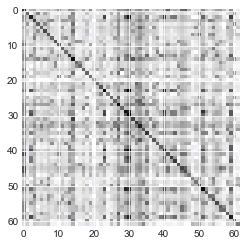

In [6]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
# mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
# networkCounty = networkCounty[['ID','mobility_parameter']]
mobility_matrix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'County']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'County'] == 0:
            mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)
    #         print(mobility_parameter_row)
            mobility_parameter_row = np.zeros(M)
    else:
         mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)

assert (np.shape(mobility_matrix)==(M,M))
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
print (np.sum(mobility_matrix_norm, axis =1))
plt.imshow(np.log(mobility_matrix))

In [11]:
print(population[0])
np.mean(np.diagonal(population/mobility_matrix))


309381


8.214031552613665

In [7]:
print(patches.tolist().index('Saratoga County'))
print(np.sum(mobility_matrix, axis =1))

44
[1.00096e+05 1.17380e+04 4.20984e+05 5.71870e+04 1.98420e+04 2.57270e+04
 3.51890e+04 2.44170e+04 1.47900e+04 2.22900e+04 1.80630e+04 1.45490e+04
 1.15380e+04 9.25130e+04 3.23427e+05 9.81100e+03 1.03890e+04 1.79790e+04
 2.02790e+04 1.35370e+04 8.42000e+02 2.01000e+04 2.57360e+04 8.61065e+05
 5.87900e+03 2.10350e+04 2.28280e+04 2.79155e+05 1.51850e+04 5.05304e+05
 6.20525e+05 7.57060e+04 7.02170e+04 1.57910e+05 3.84980e+04 1.11602e+05
 1.41490e+04 3.74010e+04 1.75530e+04 3.10060e+04 7.86020e+05 5.22530e+04
 1.35347e+05 9.04050e+04 2.40900e+04 8.18910e+04 5.49950e+04 7.47800e+03
 5.39700e+03 9.29300e+03 2.79630e+04 5.54122e+05 2.01820e+04 1.51870e+04
 3.02380e+04 5.51150e+04 2.09760e+04 1.79740e+04 3.35450e+04 3.00289e+05
 1.24130e+04 6.28700e+03]


In [8]:
# Getting the time length
time_S = np.unique(results['time'].values)
Time_S = len(time_S)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, Time_S, M, C))
start_time = 30
end_time = 75
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
        
# start_time = 50
# end_time = 100  

        
start_time = 70
end_time = 201  

Time = end_time - start_time
p = 0
print(ref_traj.shape)
ref_traj = ref_traj[:, start_time:end_time,:,:]
ref_traj[p,:,:,4] +=  ref_traj[p,:,:,5] + ref_traj[p,:,:,6]
ref_traj = ref_traj[p,:,:,:5]
# REF=ref_traj

## Combining P and D compartments into R
# ref_traj = ref_traj[:,:,:]
ref_traj = ref_traj[np.newaxis,:,:,:]
print (np.shape(ref_traj))
print(Time)

(1, 201, 62, 7)
(1, 131, 62, 5)
131


In [37]:
# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)
population[0:10]

[309381, 47462, 1455444, 196567, 77922, 78288, 130779, 87071, 48844, 81251]

In [10]:
## make a maxentep traj to compare 
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
eta = 1/2.6
alpha = 1/2.6
mu = 1/3.2
tmat.add_transition('E', 'A', 1/eta, 0)
tmat.add_transition('A', 'I', 1/alpha, 0)
tmat.add_transition('I', 'R', 1/mu, 0)

infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
timesteps = 202
model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# assume starting from Bronx county
exposed_Bronx = 1/population[2]
start[2,0] = exposed_Bronx
# start[0,0] = 0.05
beta = 0.04
m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
m_ref_traj = m_ref_traj[np.newaxis,70:201,:,:]

m_ref_traj.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([1, 131, 62, 5])

Plotting 62 patches in a 7 x 9 grid


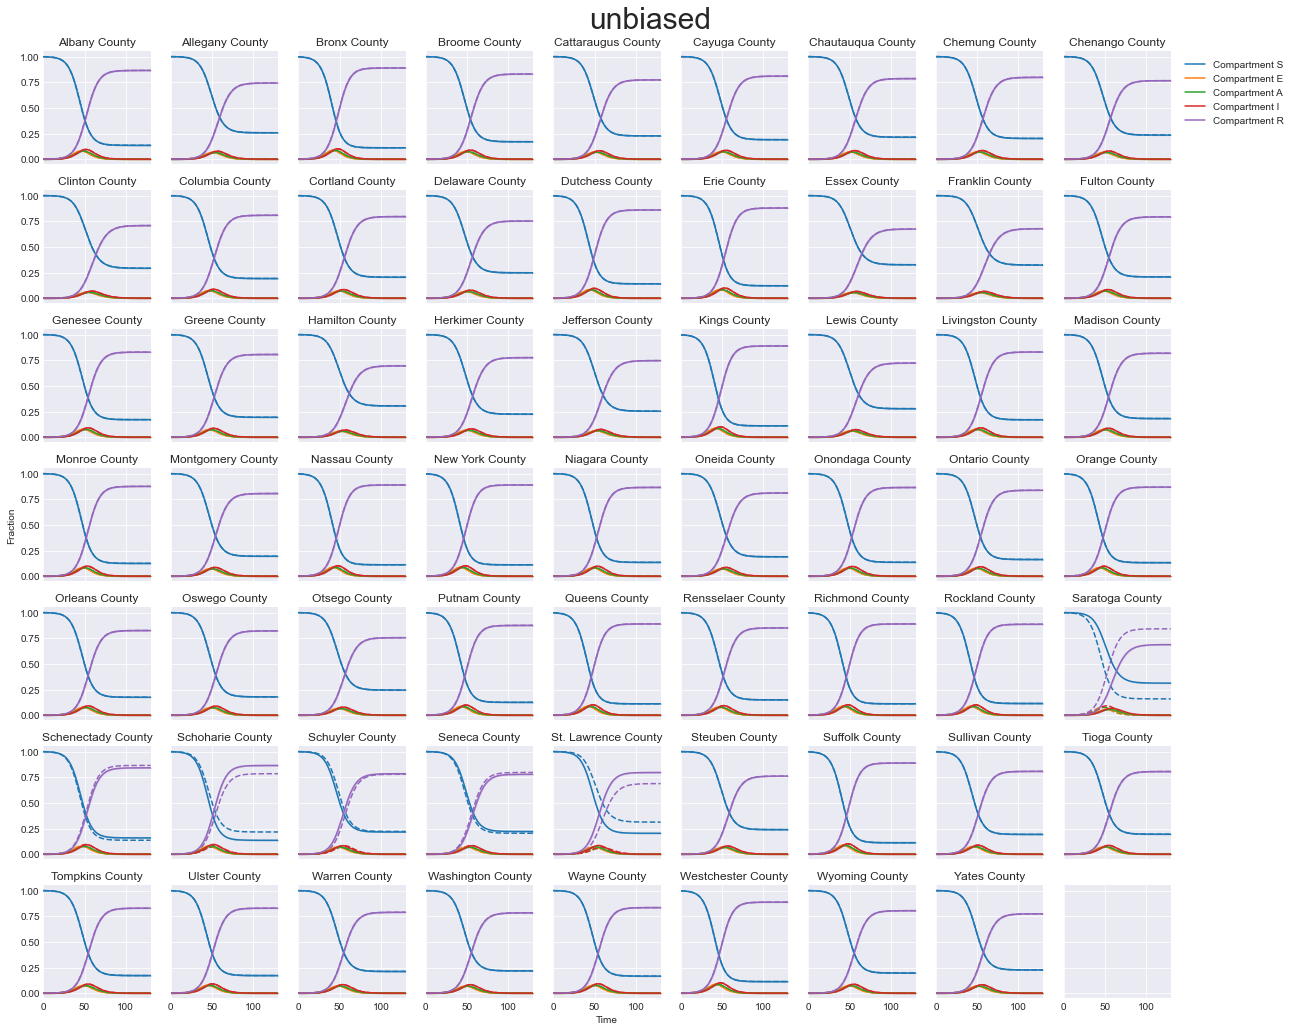

In [11]:
compare_to_ref(ref_traj, m_ref_traj, weights=None, method='unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)

In [12]:
# patch_quantile(m_ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
ref_traj = m_ref_traj

In [13]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [tf.round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

In [14]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()
print (ref_traj.shape)

(1, 131, 62, 5)


In [36]:
# mobility_matrix=np.zeros_like(mobility_matrix)
# for i in range(M):
#     mobility_matrix[i,i] = 0.9
#     mobility_matrix[i, (i+1)%M] = 0.1
# np.sum(population)
# print(population)
mobility_matrix[0]

array([5.9432e+04, 1.8000e+01, 2.2400e+02, 3.2200e+02, 1.4000e+01,
       4.9000e+01, 5.0000e+01, 1.1700e+02, 4.5000e+01, 1.0600e+02,
       6.2600e+02, 5.1000e+01, 4.8000e+01, 7.3000e+02, 5.5100e+02,
       5.8000e+01, 2.4000e+01, 3.1700e+02, 2.0000e+01, 8.3000e+02,
       4.0000e+00, 6.3000e+01, 9.5000e+01, 4.7900e+02, 1.6000e+01,
       2.3000e+01, 6.9000e+01, 9.4500e+02, 4.9700e+02, 1.2020e+03,
       3.7270e+03, 8.1000e+01, 5.9100e+02, 1.0800e+03, 1.0400e+02,
       6.4700e+02, 1.1000e+01, 7.3000e+01, 1.7800e+02, 5.3000e+01,
       6.0000e+02, 7.9410e+03, 1.0800e+02, 2.8700e+02, 1.0600e+02,
       5.9130e+03, 7.5470e+03, 2.7500e+02, 7.0000e+00, 2.7000e+01,
       5.1000e+01, 1.1600e+03, 9.0000e+01, 2.2000e+01, 1.2100e+02,
       4.5300e+02, 6.0800e+02, 1.3900e+02, 1.5000e+01, 1.0460e+03,
       3.0000e+00, 7.0000e+00])

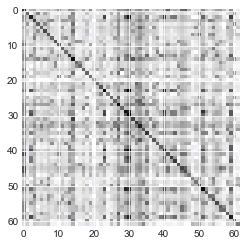

In [16]:
plt.imshow(np.log(mobility_matrix))

## Restraining a sample SEAIRPD to reference

In [17]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 4, 3)
tmat.add_transition('A', 'I', 2, 3)
tmat.add_transition('I', 'R', 5, 3)
#tmat.add_transition('I', 'P', 5, 2)
#tmat.add_transition('P', 'D', 5, 2)
#tmat.add_transition('D', 'R', 5, 2)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.005
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = 0.05
hyper_pram.beta_var = 0.8
hyper_pram.start_high = 0.05
hyper_pram.start_var = 0.5
hyper_pram.R_var = 500
hyper_pram.beta_start = 0.01
hyper_pram.start_mean = 0.01
hyper_pram.start_scale = 0.01

start_logits = np.zeros((M))
# start_logits[:]= 0
param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram )

[[0.75 0.25 0.   0.  ]
 [0.   0.5  0.5  0.  ]
 [0.   0.   0.8  0.2 ]
 [0.   0.   0.   1.  ]]


In [18]:
v = param_model.sample(1)
start_dist = v[2]
start_dist


<tf.Tensor: shape=(62, 4), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.     

<tf.Tensor: shape=(1, 62, 62), dtype=float32, numpy=
array([[[5.93738437e-01, 1.89405619e-04, 2.25185649e-03, 3.22175678e-03,
         1.41645403e-04, 4.74820787e-04, 5.06216311e-04, 1.17055781e-03,
         4.59615927e-04, 1.04425265e-03, 6.26828521e-03, 4.87929763e-04,
         4.86143457e-04, 7.30352290e-03, 5.51186735e-03, 5.96009137e-04,
         2.37388478e-04, 3.14114522e-03, 1.80026560e-04, 8.29129480e-03,
         4.49273866e-05, 6.23931061e-04, 9.51528491e-04, 4.78950329e-03,
         1.58510404e-04, 2.26678967e-04, 6.97747222e-04, 9.43867210e-03,
         4.96287178e-03, 1.20229330e-02, 3.72278281e-02, 8.04584182e-04,
         5.89834899e-03, 1.07872728e-02, 1.03712967e-03, 6.46154070e-03,
         1.05719839e-04, 7.43355020e-04, 1.76842930e-03, 5.38007473e-04,
         6.00143149e-03, 7.93350935e-02, 1.08696916e-03, 2.87695765e-03,
         1.06267817e-03, 5.90628125e-02, 7.53984600e-02, 2.76243920e-03,
         6.34876487e-05, 2.51086749e-04, 5.13714913e-04, 1.15978522e-02

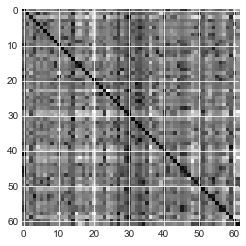

In [19]:
R = v[0]

plt.imshow(np.log(R[0]))
R

In [20]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
        R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
    R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get alpha
    A_I = 1/T_dist[:, compartments.index('A'), compartments.index('I')].numpy()
    # get mu
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist]
    
def plot_dist(R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist, name='prior'):
    import seaborn as sns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,6), dpi=200)
    fig.suptitle(f'Parameter {name} distributions', fontsize=20,y=1.00)
    sns.distplot(x=beta_dist, ax = axs[0,0], axlabel='Beta')
    sns.distplot(x=start_exposed_dist, ax = axs[0,1], axlabel='Exposed start fraction')
    sns.distplot(x=R_dist, ax = axs[0,2], axlabel='Mobility matrix')
    sns.distplot(x=E_A, ax = axs[1,0], axlabel=r'$\eta^{-1}$ : E->A (days)')
    sns.distplot(x=A_I, ax = axs[1,1], axlabel=r'$\alpha ^{-1}$ : A->I (days)')
    sns.distplot(x=I_R, ax = axs[1,2], axlabel=r'$\mu^{-1}$ : I->R (days)')

In [21]:
import tqdm
N = 1024
batches = 8
outs = []
infect = maxentep.contact_infection_func(infections_compartments, area = area)
# model = maxentep.MetaModel(infect, Time,populations = np.round(population))
model = maxentep.MetaModel(infect, Time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
#     R_dist= ps[0]
#     output_list = []
#     for i in range(R_dist.shape[0]):
#         R_dist_d = tf.linalg.set_diag(R_dist[i].numpy(), np.diagonal(R_dist[i])*10)
#         norm_R_dist_d = R_dist_d/ tf.math.reduce_sum(R_dist_d, axis = 1, keepdims=True)
#         output_list.append(norm_R_dist_d)
#     outputs = tf.stack(output_list)
#     ps[0] = outputs
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:30<00:00,  3.80s/it]


(8192, 131, 62, 5)


(array([   8,  192,  252,  502,  644,  717,  737,  754,  817,  851,  874,
       1066, 1081, 1124, 1301, 1351, 1453, 1699, 1862, 1875, 1964, 2206,
       2312, 2336, 2379, 2416, 2442, 2452, 2536, 2575, 2576, 2646, 2761,
       2894, 2907, 2921, 2986, 3005, 3046, 3075, 3078, 3094, 3140, 3151,
       3184, 3278, 3287, 3462, 3557, 3681, 3707, 3870, 3877, 3881, 3985,
       4041, 4107, 4122, 4128, 4167, 4173, 4196, 4268, 4327, 4378, 4409,
       4473, 4526, 4569, 4571, 4577, 4579, 4587, 4619, 4621, 4659, 4705,
       4708, 4861, 5115, 5172, 5256, 5263, 5333, 5460, 5465, 5508, 5516,
       5558, 5561, 5621, 5726, 5865, 5869, 6014, 6067, 6149, 6195, 6328,
       6343, 6498, 6560, 6663, 6732, 6825, 6852, 6909, 6920, 6965, 7030,
       7074, 7096, 7131, 7164, 7282, 7295, 7466, 7523, 7549, 7655, 7678,
       8008, 8044, 8051, 8096], dtype=int64),)


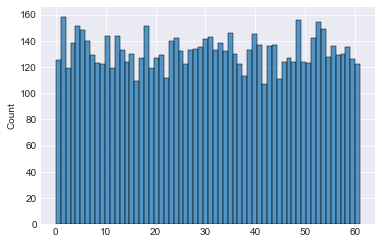

In [22]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch, label='Prior',
            color='C0',bins=M)

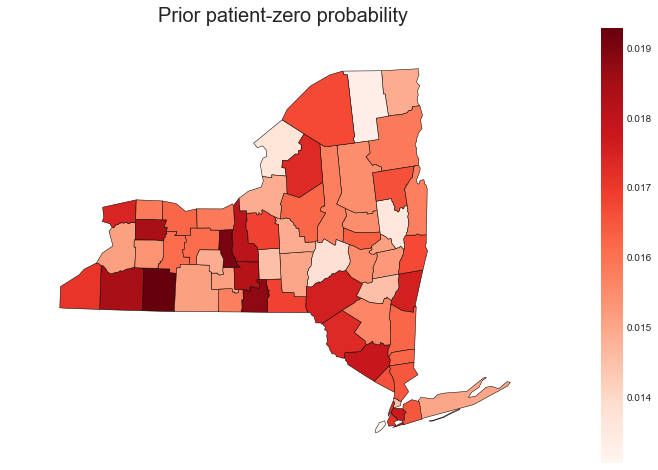

In [23]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')

In [24]:
prior_param_dist = get_dist(prior_prams)

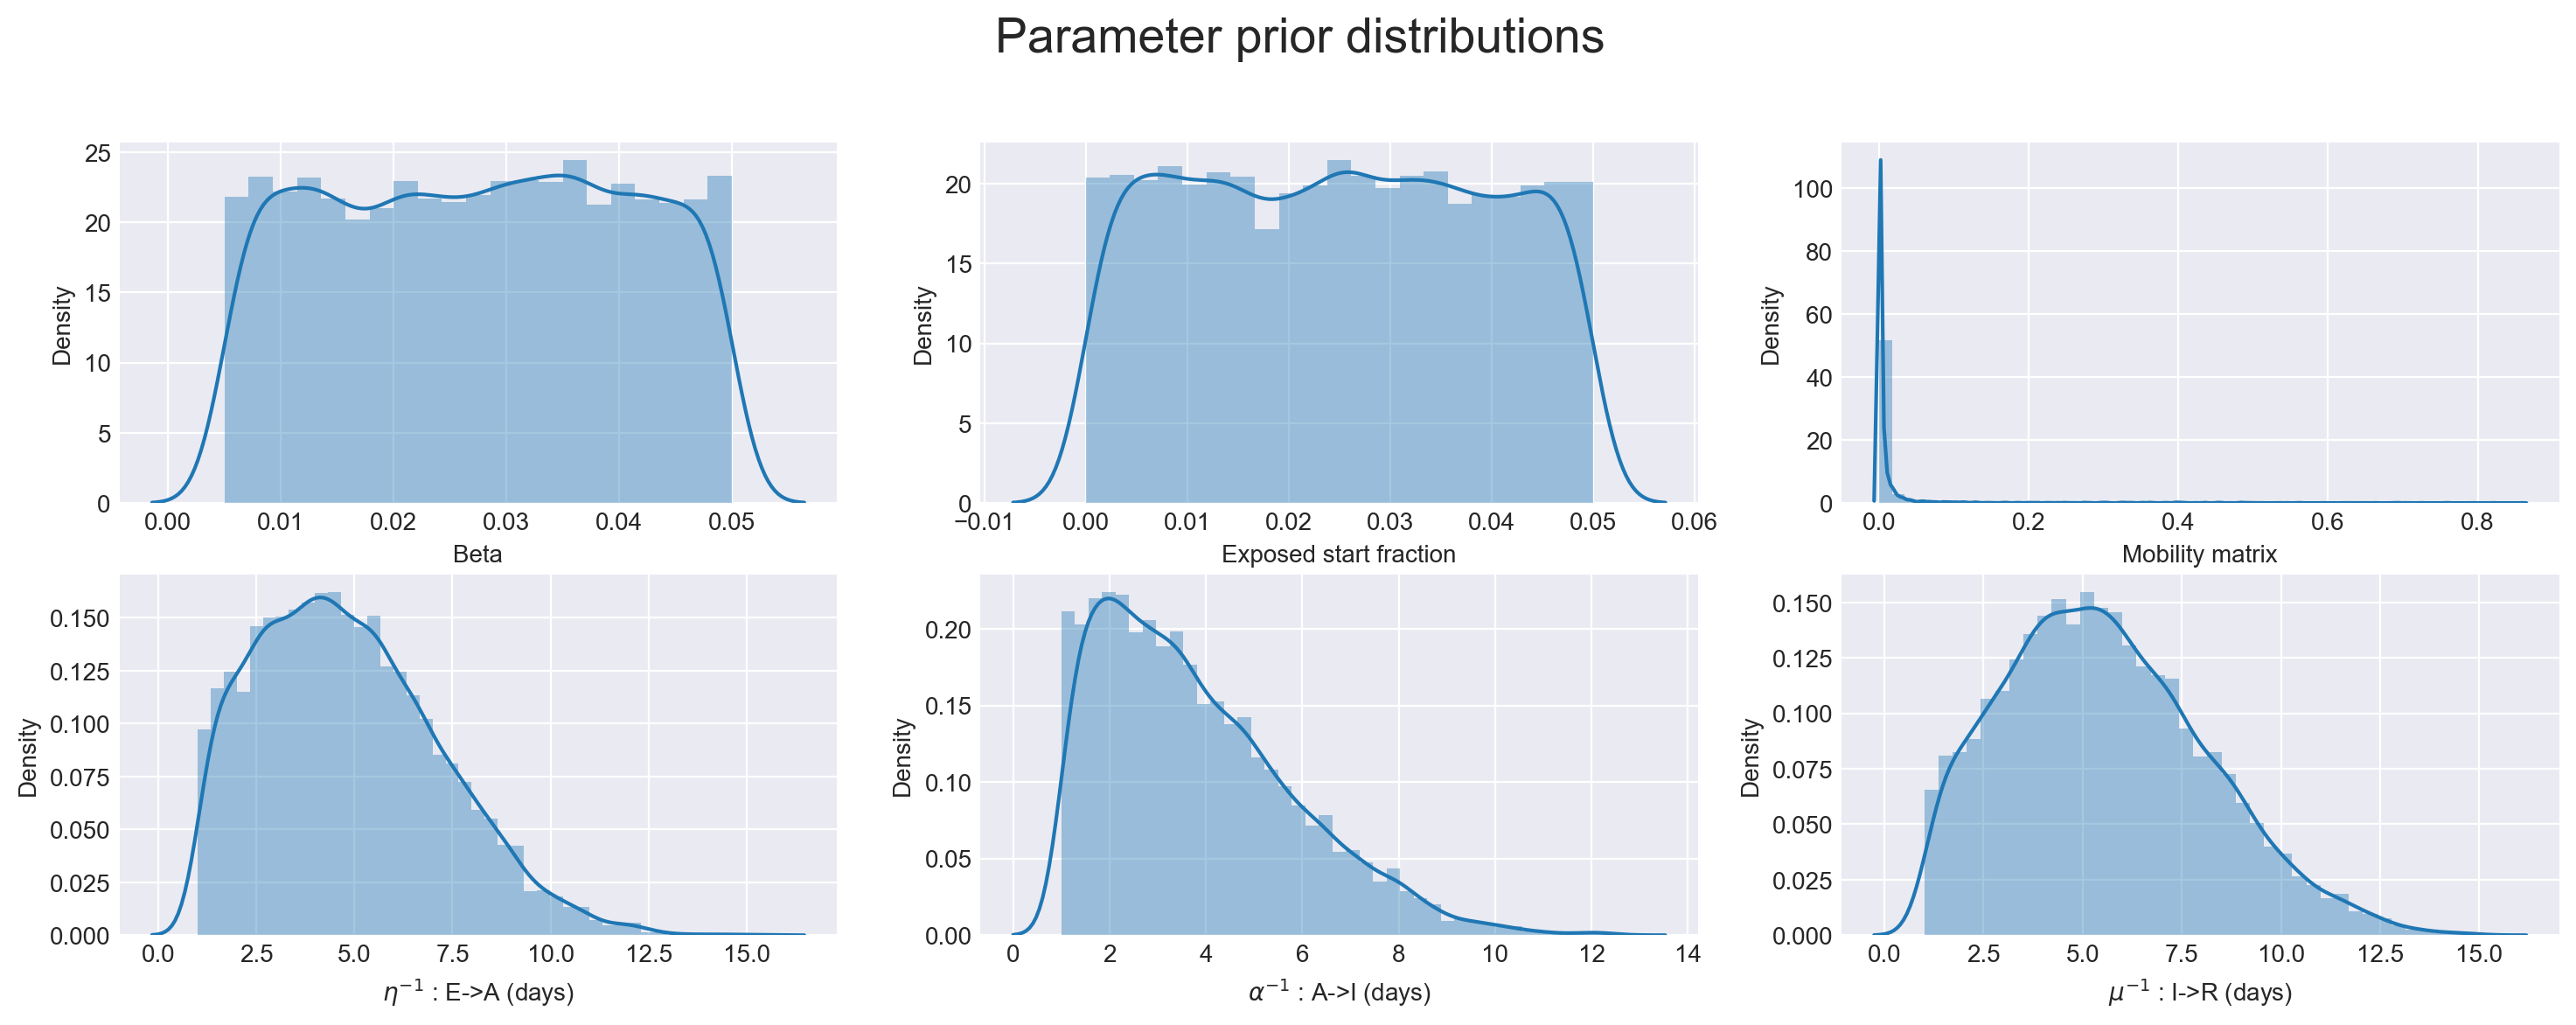

In [25]:
plot_dist(*prior_param_dist)

## Visualizing the unbiased traj

In [26]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments


Plotting 62 patches in a 7 x 9 grid


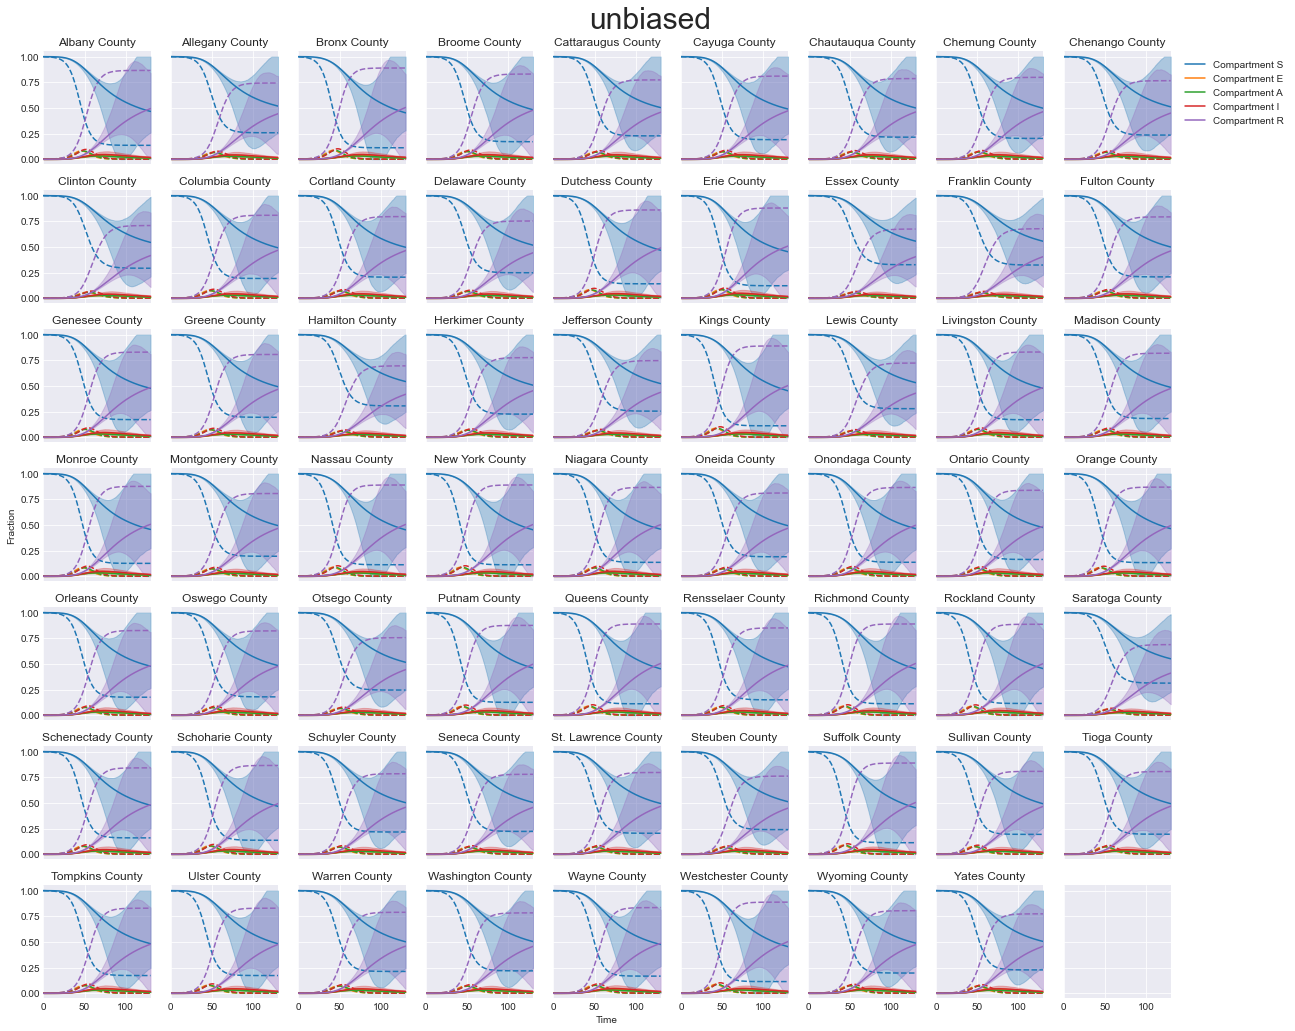

In [27]:
compare_to_ref(ref_traj,trajs, weights=None, method='unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)

## Make restraints from reference trajectory

I R
73 0.010388344 0.010478244748709486
3 0.00067909755 0.01292495257626116
31 0.03220505 0.03161211185889281
38 0.06566693 0.05949530791427199
24 0.013236041 0.0051188517372439575
66 0.026205976 0.02729686853187134
73 0.8644833 0.8662238073436357
3 0.001365945 0.0
10 0.0037505387 0.01890702352064104
31 0.071835995 0.06885665117057382
17 0.010249903 0.0036636898464035006
59 0.7314815 0.7220834998766796
66 0.047821242 0.032254576458699905
52 0.08384507 0.08577282460823743
45 0.06270786 0.06229141624663958
59 0.07520777 0.08958943728010714
31 0.014264716 0.012758184927332062
10 0.00073558924 0.005914912904169308
38 0.07685678 0.08290461692884295
73 0.73867196 0.7319258199947597
59 0.5182215 0.5272925921130133
45 0.17634903 0.1830915084411767
17 0.004048932 0.0007623158675717379
66 0.6580356 0.6525895817033323
38 0.031202063 0.02196118613959272
10 0.0006514587 0.0
66 0.051816132 0.038942668919966894
24 0.0049762777 0.006624143572342513
17 0.0018169337 0.0
59 0.07959546 0.09265984991918066

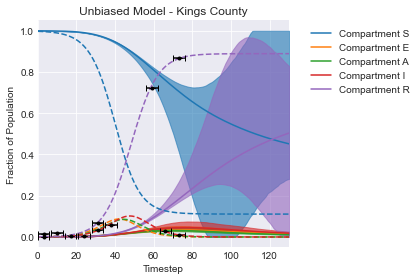

I R
[23 28 37 29  9]
23


In [28]:
full_compartments = ['S'] + compartments
npoints = 6
prior = maxentep.EmptyPrior()
# prior = maxentep.Laplace(0.1)
# p = 0

# restrained_patches = np.random.randint(M, size=number_of_restraint_patches)
number_of_restrained_patches = 5 
restrained_compartments = [3,4] #(infected patch and recovered)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
print (restrained_compartments_names)
number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]
def compartment_restrainer(number_of_restrained_patches,number_of_restrained_compartments,npoints,ref_traj,prior,noise=0,time_average=7):
    if number_of_restrained_patches > M:
        raise ValueError(
            "Oops! Number of patches to be restrained exceeeds the total number of patches.")
#     p = 0  # picking one trajectory from the parameter set (pick the first 1)
    # example if number_of_restraint_patches = 2 : (recovered and infected patch)
    restraints =[] 
    plot_fxns_list = []
    for i in range(number_of_restrained_patches):
        plot_fxns = []
        for j in range(number_of_restrained_compartments):
            res, plfxn = maxentep.traj_to_restraints(ref_traj[p,:80,:,:], [restrained_patches[i],restrained_compartments[j]], npoints, prior, noise,time_average)
            restraints += res 
            plot_fxns += plfxn
        plot_fxns_list.append(plot_fxns)
    return restraints, plot_fxns_list


restraints, plot_fxns_list = compartment_restrainer(number_of_restrained_patches,number_of_restrained_compartments,npoints,ref_traj,prior, noise=0.01)
maxentep.traj_quantile(trajs[:,:,restrained_patch,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,restrained_patch,:], linestyle='--')
plt.title('Unbiased Model - {}'.format(patches[restrained_patch]))
for i,pf in enumerate(plot_fxns_list[0]):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.show()
print (restrained_compartments_names)
print(restrained_patches)
print(restrained_patch)

In [29]:

print (restrained_compartments_names)
# npoints =4
# prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
# restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,4], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
# restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
# restraints = restraints_I + restraints_R
# plot_fxns = plot_fxn_I + plot_fxn_R


I R


In [30]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [31]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self. i = 0
#     def on_epoch_begin(self, epoch, logs=None):
#         self.i += 1
#         return self.i

In [32]:
me_history = me_model.fit(trajs, batch_size=64,epochs=1000)#, callbacks=[CustomCallback()])

Epoch 1/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 2.1776
Epoch 2/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.0225
Epoch 3/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 1.7909
Epoch 4/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 1.6244
Epoch 5/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 1.5484
Epoch 6/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.5668
Epoch 7/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.5418
Epoch 8/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 1.5404
Epoch 9/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 1.5000
Epoch 10/1000
128/128 [=====

128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 1.3545
Epoch 151/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 1.2694
Epoch 152/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 1.1245
Epoch 153/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.1363
Epoch 154/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.2548
Epoch 155/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.2853
Epoch 156/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 1.3804
Epoch 157/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.3479
Epoch 158/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.3698
Epoch 159/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 1.2872
Epoch 298/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.3336
Epoch 299/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.3187
Epoch 300/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.3601
Epoch 301/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 1.3964
Epoch 302/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.2385
Epoch 303/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.2735
Epoch 304/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 1.3538
Epoch 305/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 1.3040
Epoch 306/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 1.3042
Epoch 446/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.2810
Epoch 447/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 1.2353
Epoch 448/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.2514
Epoch 449/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.2944
Epoch 450/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 1.3463
Epoch 451/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.3082
Epoch 452/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 1.3106
Epoch 453/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.2895
Epoch 454/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.3006
Epoch 594/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.3473
Epoch 595/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.3628
Epoch 596/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 1.3527
Epoch 597/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.3226
Epoch 598/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.3393
Epoch 599/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.3993
Epoch 600/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.3330
Epoch 601/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 1.3261
Epoch 602/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.2566
Epoch 742/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.2385
Epoch 743/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.3146
Epoch 744/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 1.3113
Epoch 745/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.3000
Epoch 746/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.2727
Epoch 747/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.2535
Epoch 748/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.3132
Epoch 749/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.2429
Epoch 750/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0020 - weight-entropy: 1.3221
Epoch 889/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.3230
Epoch 890/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 1.2579
Epoch 891/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 1.3243
Epoch 892/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 1.3114
Epoch 893/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0023 - weight-entropy: 1.3878
Epoch 894/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 1.2942
Epoch 895/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 1.3142
Epoch 896/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0020 - weight-entropy: 1.2474
Epoch 897/1000
128/128 [=

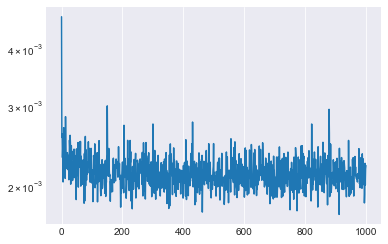

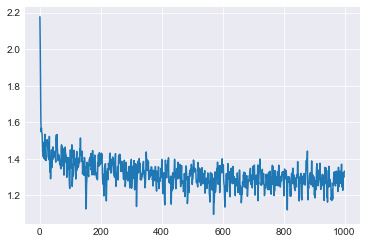

In [33]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()
plt.plot(me_history.history['weight-entropy'])
plt.show()



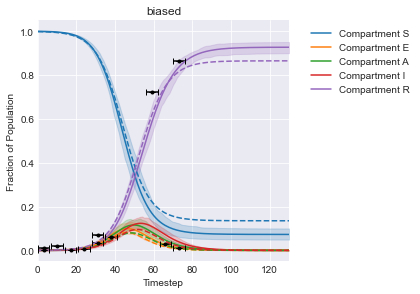

In [34]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights,alpha=0.2, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, me_model.lambdas[i], color='k')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('biased')
plt.show()

## Algorithm 2

In [93]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram )
fit_param_model.compile(tf.optimizers.SGD(1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [94]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=64, epochs=1000)

Epoch 1/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0389 - weight-entropy: 4.1351
Epoch 2/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0202 - weight-entropy: 3.8692
Epoch 3/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0088 - weight-entropy: 3.4304
Epoch 4/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0071 - weight-entropy: 3.1781
Epoch 5/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0066 - weight-entropy: 3.0656
Epoch 6/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 2.9898
Epoch 7/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0068 - weight-entropy: 3.0317
Epoch 8/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0044 - weight-entropy: 2.9368
Epoch 9/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0057 - weight-entropy: 2.9499
Epoch 10/1000
16/16 [=========================

16/16 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 2.5541
Epoch 147/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.5431
Epoch 148/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 2.5311
Epoch 149/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0041 - weight-entropy: 2.5581
Epoch 150/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.5402
Epoch 151/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.5177
Epoch 152/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.5219
Epoch 153/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.5365
Epoch 154/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.5301
Epoch 155/1000
16/16 [=====================

Epoch 222/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.4895
Epoch 223/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.5011
Epoch 224/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.4848
Epoch 225/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.4571
Epoch 226/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.4615
Epoch 227/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.5069
Epoch 228/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.4763
Epoch 229/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.4584
Epoch 230/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.5005
Epoch 231/1000
16/16 [======

Epoch 373/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.4663
Epoch 374/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 2.5014
Epoch 375/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.4611
Epoch 376/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 2.5025
Epoch 377/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.4834
Epoch 378/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.4936
Epoch 379/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 2.4852
Epoch 380/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.4590
Epoch 381/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.4775
Epoch 382/1000
16/16 [======

Epoch 524/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.4570
Epoch 525/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 2.4783
Epoch 526/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.4676
Epoch 527/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.4583
Epoch 528/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.4701
Epoch 529/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.4578
Epoch 530/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.4557
Epoch 531/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 2.4836
Epoch 532/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.4919
Epoch 533/1000
16/16 [======

Epoch 675/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.4436
Epoch 676/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 2.4367
Epoch 677/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.4411
Epoch 678/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0058 - weight-entropy: 2.5478
Epoch 679/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 2.4380
Epoch 680/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.4184
Epoch 681/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 2.4465
Epoch 682/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.4214
Epoch 683/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.4215
Epoch 684/1000
16/16 [======

Epoch 826/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.4435
Epoch 827/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.3783
Epoch 828/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.3953
Epoch 829/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.4019
Epoch 830/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.3901
Epoch 831/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 2.4334
Epoch 832/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.4033
Epoch 833/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.3899
Epoch 834/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.3668
Epoch 835/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.3833
Epoch 977/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.3664
Epoch 978/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 2.4290
Epoch 979/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.3792
Epoch 980/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.4022
Epoch 981/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.3717
Epoch 982/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.3945
Epoch 983/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.3949
Epoch 984/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.3751
Epoch 985/1000
16/16 [=====================

16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.3684
Epoch 38/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.3744
Epoch 39/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.3765
Epoch 40/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.3996
Epoch 41/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.4076
Epoch 42/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 2.3968
Epoch 43/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.3728
Epoch 44/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.4123
Epoch 45/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.3509
Epoch 46/1000
16/16 [==============================

16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.3561
Epoch 189/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.4076
Epoch 190/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 2.3686
Epoch 191/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.4584
Epoch 192/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.3449
Epoch 193/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.3780
Epoch 194/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.3776
Epoch 195/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.3734
Epoch 196/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.3756
Epoch 197/1000
16/16 [=====================

Epoch 264/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.3769
Epoch 265/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 2.3536
Epoch 266/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 2.3780
Epoch 267/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.3643
Epoch 268/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.3575
Epoch 269/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.3906
Epoch 270/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.3851
Epoch 271/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.3932
Epoch 272/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.4377
Epoch 273/1000
16/16 [======

Epoch 415/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.3361
Epoch 416/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.3218
Epoch 417/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.3497
Epoch 418/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 2.3577
Epoch 419/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.3741
Epoch 420/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.3134
Epoch 421/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.3460
Epoch 422/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.3327
Epoch 423/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 2.3125
Epoch 424/1000
16/16 [======

Epoch 566/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.3372
Epoch 567/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.3270
Epoch 568/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 2.3091
Epoch 569/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.3513
Epoch 570/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.3321
Epoch 571/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.3178
Epoch 572/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.3773
Epoch 573/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.3341
Epoch 574/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.3390
Epoch 575/1000
16/16 [======

Epoch 717/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.3332
Epoch 718/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.2679
Epoch 719/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 2.2937
Epoch 720/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.3060
Epoch 721/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.2728
Epoch 722/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.2779
Epoch 723/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.2840
Epoch 724/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.2913
Epoch 725/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.2919
Epoch 726/1000
16/16 [======

Epoch 868/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.2599
Epoch 869/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.2809
Epoch 870/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.2675
Epoch 871/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.3453
Epoch 872/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 2.2686
Epoch 873/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.3065
Epoch 874/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.2962
Epoch 875/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.2558
Epoch 876/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.3081
Epoch 877/1000
16/16 [======

32/32 [==============================] - 0s 12ms/step - loss: 4.8563 - R-dist-dist_loss: 5.1320 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -0.1774 - beta-dist_loss: -0.0969
Epoch 11/50
32/32 [==============================] - 0s 11ms/step - loss: 4.8557 - R-dist-dist_loss: 5.1315 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -0.1774 - beta-dist_loss: -0.0969
Epoch 12/50
32/32 [==============================] - 0s 13ms/step - loss: 4.8552 - R-dist-dist_loss: 5.1309 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -0.1774 - beta-dist_loss: -0.0969
Epoch 13/50
32/32 [==============================] - 0s 13ms/step - loss: 4.8547 - R-dist-dist_loss: 5.1304 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -0.1774 - beta-dist_loss: -0.0969
Epoch 14/50
32/32 [==============================] - 0s 11ms/step - loss: 4.8542 - R-dist-dist_loss: 5.1300 - T-dist-dist_loss: -0.0014 - rho-dist-dist_loss: -0.1774 - beta-dist_loss: -0.0969
Epoch 15/50
32/32 [==============================] -

128/128 [==============================] - 0s 1ms/step - loss: 0.0035 - weight-entropy: 2.6452
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 2.6139
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.6155
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 2.6428
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.5878
Epoch 9/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 2.5941
Epoch 10/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.5687
Epoch 11/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.5519
Epoch 12/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.5414
Epoch 13/1000
128/128 [===============

128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.2900
Epoch 154/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.2908
Epoch 155/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.2929
Epoch 156/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.3156
Epoch 157/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.2854
Epoch 158/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.2859
Epoch 159/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.2986
Epoch 160/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.2946
Epoch 161/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.3174
Epoch 162/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.1677
Epoch 302/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.1749
Epoch 303/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.1406
Epoch 304/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.1496
Epoch 305/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.1661
Epoch 306/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.1582
Epoch 307/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.1560
Epoch 308/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.1525
Epoch 309/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.1592
Epoch 310/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.0998
Epoch 450/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.0963
Epoch 451/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.0773
Epoch 452/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.0743
Epoch 453/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.0758
Epoch 454/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.0955
Epoch 455/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 2.0758
Epoch 456/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.0680
Epoch 457/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.0819
Epoch 458/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.0110
Epoch 598/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.0250
Epoch 599/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.0333
Epoch 600/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.0166
Epoch 601/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.0331
Epoch 602/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.0486
Epoch 603/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.0261
Epoch 604/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.0493
Epoch 605/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.0320
Epoch 606/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 1.9997
Epoch 745/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.0133
Epoch 746/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.0068
Epoch 747/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.0068
Epoch 748/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.0047
Epoch 749/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 2.0052
Epoch 750/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.0110
Epoch 751/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 1.9892
Epoch 752/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.9833
Epoch 753/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.9729
Epoch 893/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9676
Epoch 894/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 1.9861
Epoch 895/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 1.9984
Epoch 896/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.9860
Epoch 897/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9792
Epoch 898/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9839
Epoch 899/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 1.9809
Epoch 900/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9724
Epoch 901/1000
128/128 [=

In [95]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=1000)

Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0099 - weight-entropy: 3.1120
Epoch 2/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0040 - weight-entropy: 2.7149
Epoch 3/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 2.6343
Epoch 4/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 2.6224
Epoch 5/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.6112
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 2.5970
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 2.5486
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 2.5978
Epoch 9/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.5303
Epoch 10/1000
128/128 [=====

128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9035
Epoch 145/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9009
Epoch 146/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 1.9618
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 1.8991
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9343
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.8909
Epoch 150/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9058
Epoch 151/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9078
Epoch 152/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.9074
Epoch 153/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 1.8842
Epoch 293/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 1.9027
Epoch 294/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 1.9276
Epoch 295/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 1.9075
Epoch 296/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 1.9077
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9009
Epoch 298/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.8995
Epoch 299/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9121
Epoch 300/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9129
Epoch 301/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.8970
Epoch 441/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9164
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.8742
Epoch 443/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 1.9070
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 1.9058
Epoch 445/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.9043
Epoch 446/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.8641
Epoch 447/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 1.8798
Epoch 448/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.8905
Epoch 449/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.8534
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8983
Epoch 590/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8986
Epoch 591/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 1.8880
Epoch 592/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9118
Epoch 593/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8704
Epoch 594/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 1.9182
Epoch 595/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.8323
Epoch 596/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8625
Epoch 597/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9032
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8958
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9234
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9320
Epoch 740/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.9467
Epoch 741/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9353
Epoch 742/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9209
Epoch 743/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.8903
Epoch 744/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 1.9162
Epoch 745/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8717
Epoch 885/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8403
Epoch 886/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.9005
Epoch 887/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9102
Epoch 888/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8967
Epoch 889/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8948
Epoch 890/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.8814
Epoch 891/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.8449
Epoch 892/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 1.9263
Epoch 893/1000
128/128 [=

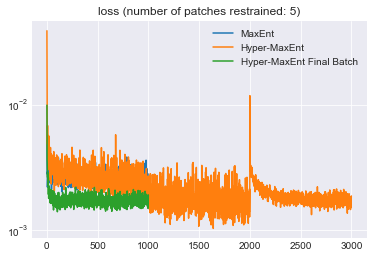

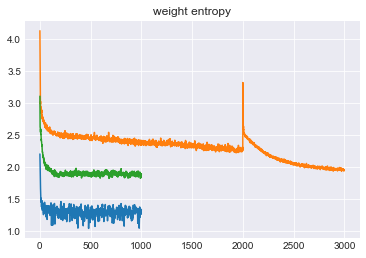

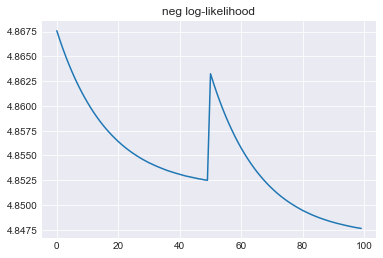

In [96]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

# plt.plot(hme_history.history['loss-from-ref'])
# plt.show()

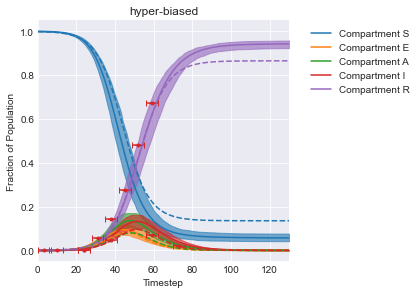

In [97]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('hyper-biased')
plt.show()


## Direct Regression of Model

In [98]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 0.01
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments, area=area)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, mobility_matrix, T, infect, Time, agreement, populations=population)

In [99]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

150/150 [==============================] - 19s 127ms/step - loss: 2.4729 - output_2_loss: 2.4729


## Visualizing results

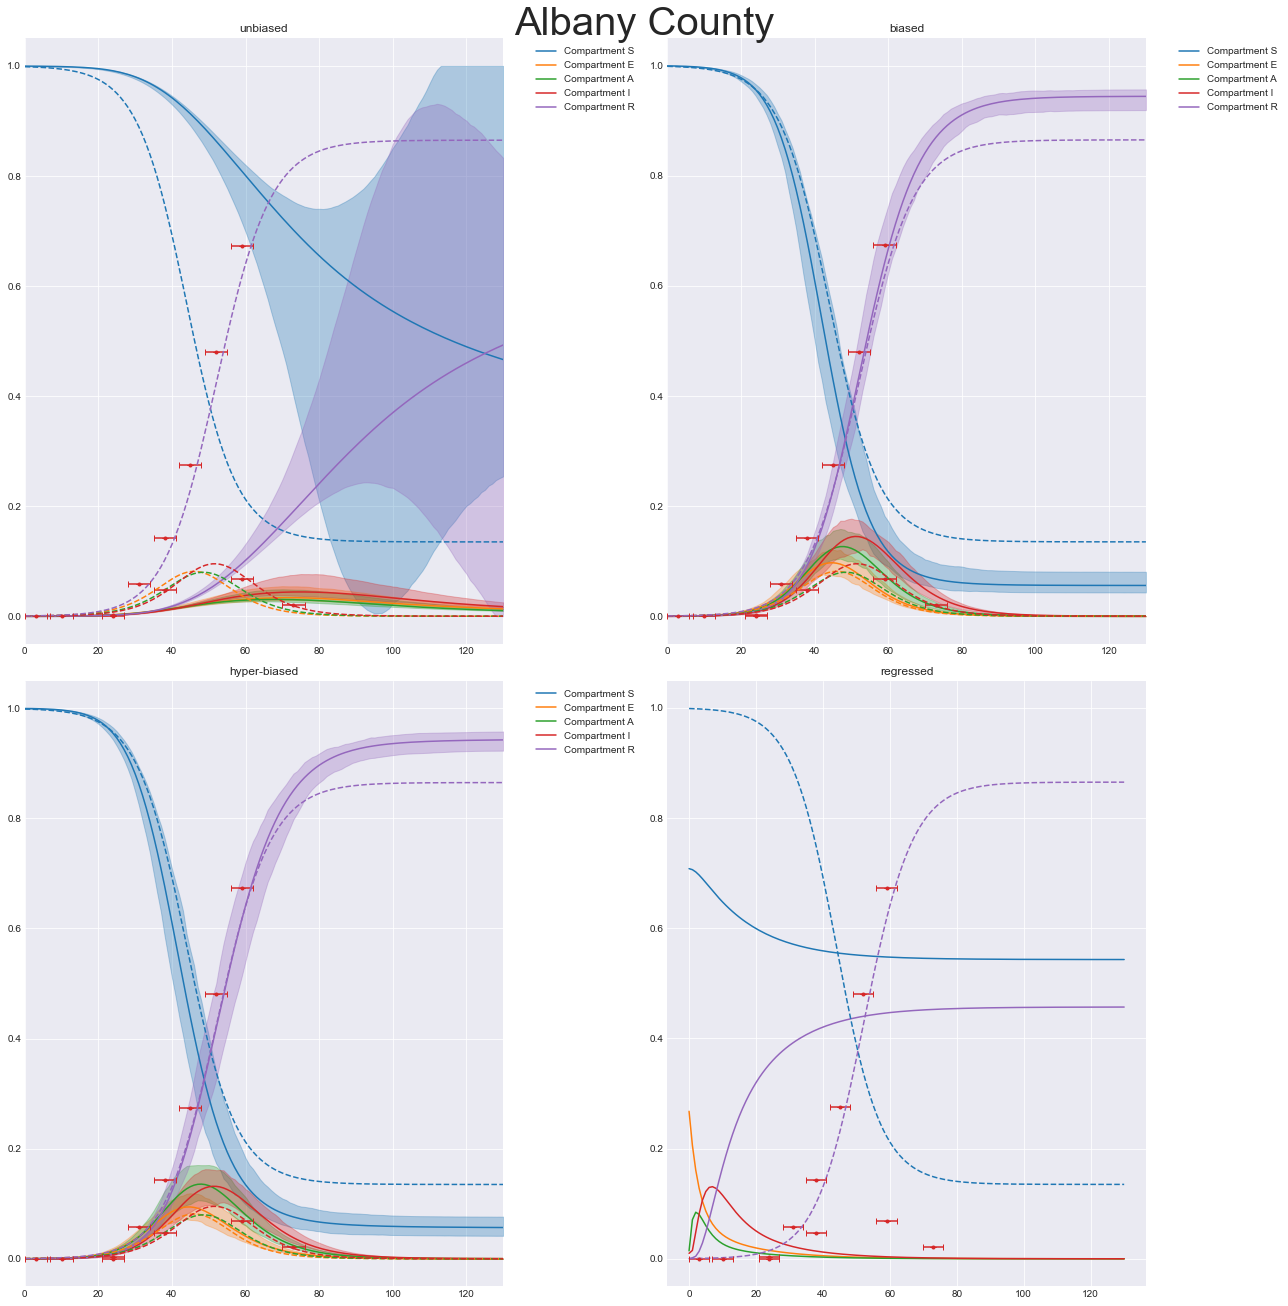

In [100]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')

for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments,alpha = 0.3, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], alpha = 0.3,weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

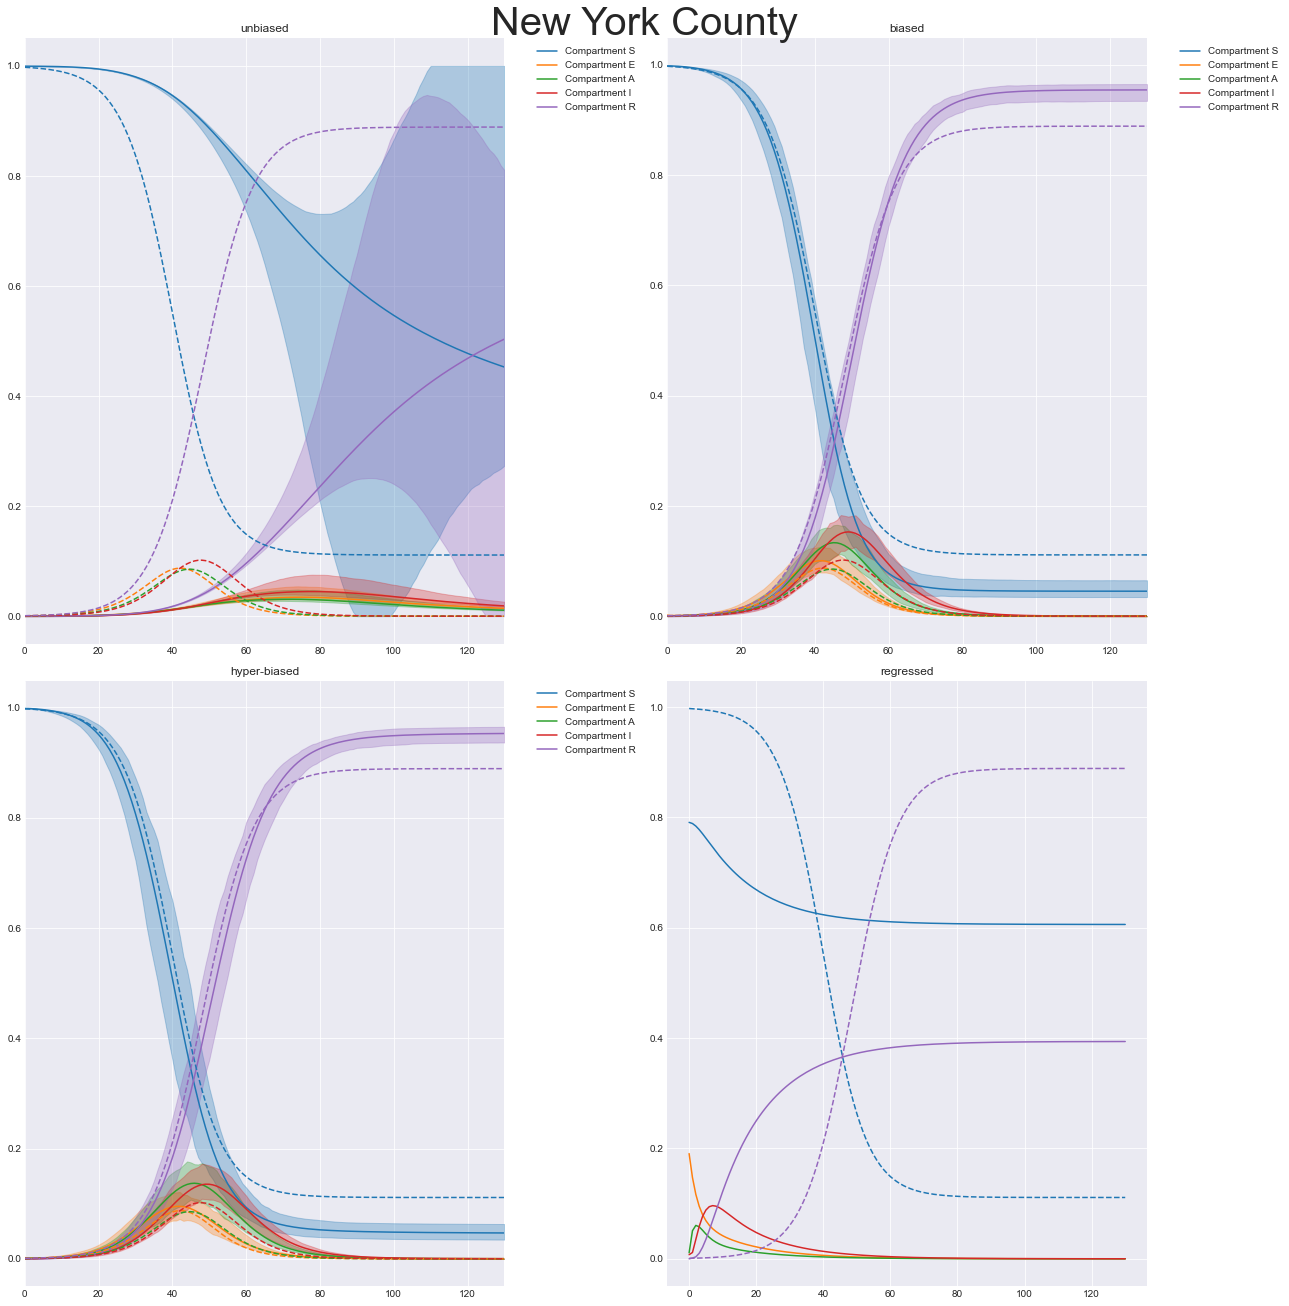

In [101]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# ax[0,0].tick_params(color='green', labelcolor='green')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

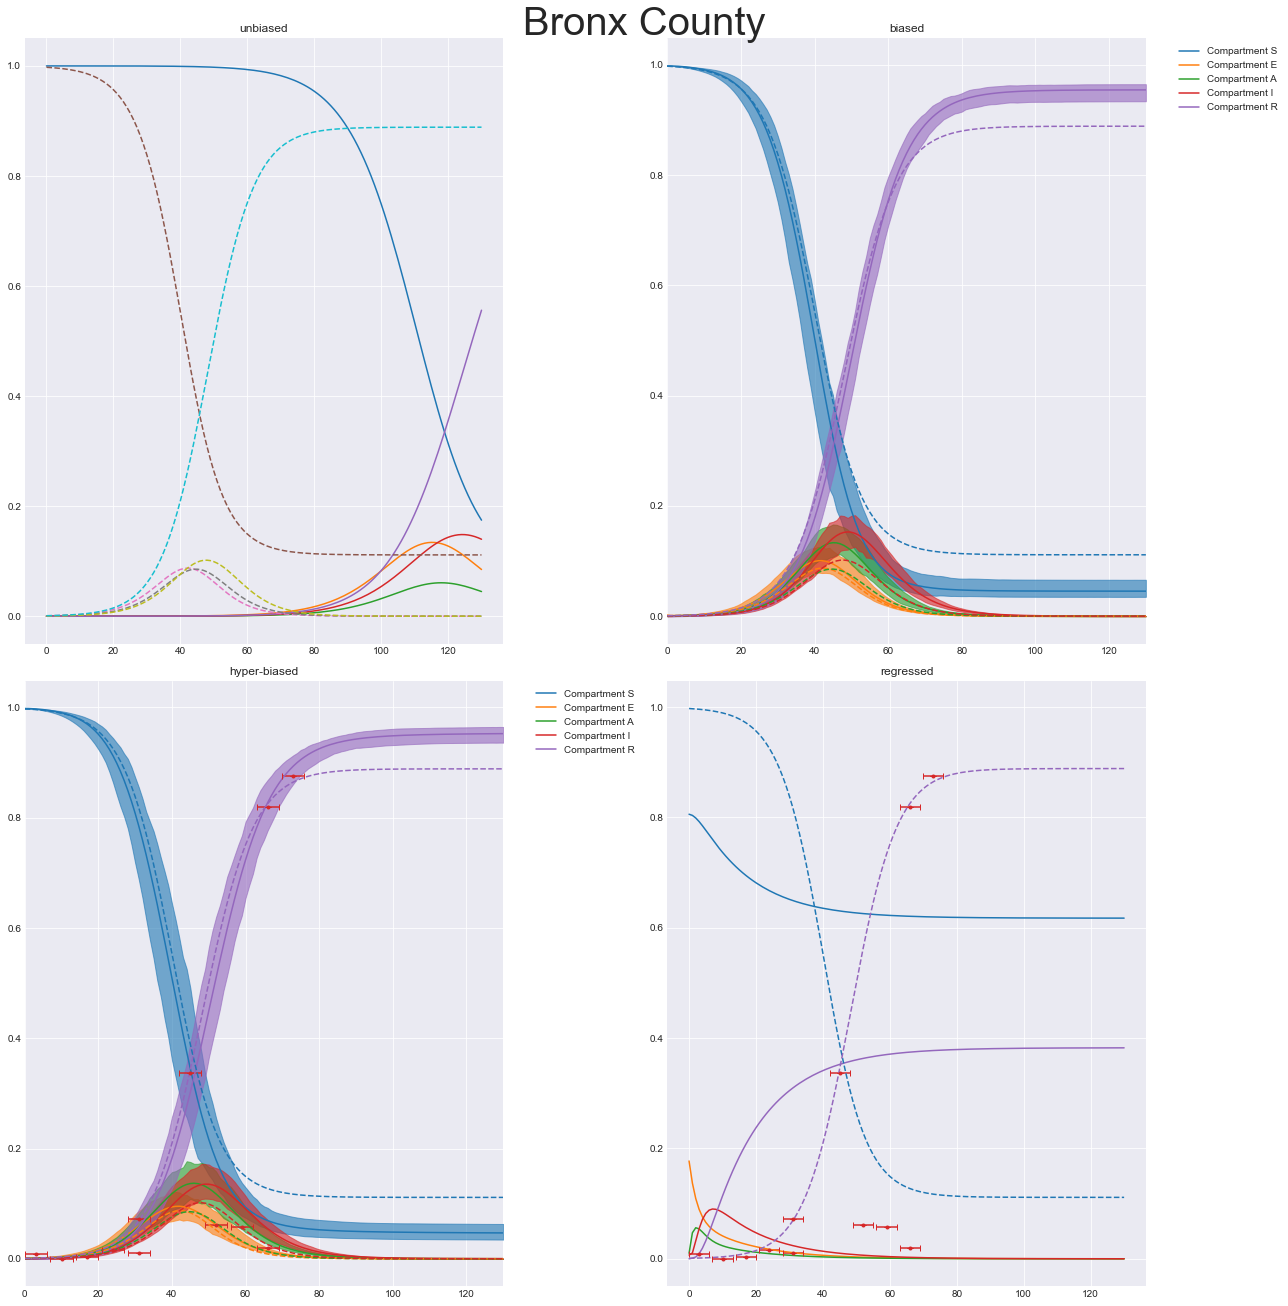

(1, 131, 62, 5)


In [102]:
patch_number = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
axs[0,0].plot(trajs[0,:,patch_number,:])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
print (ref_traj.shape)

In [103]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':hme_model.traj_weights, 'regression':None }
from matplotlib.patches import Patch
print (restrained_patches)
def compare_patches(ref_traj,trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


[13 43 23 38 58]


Plotting 62 patches in a 7 x 9 grid


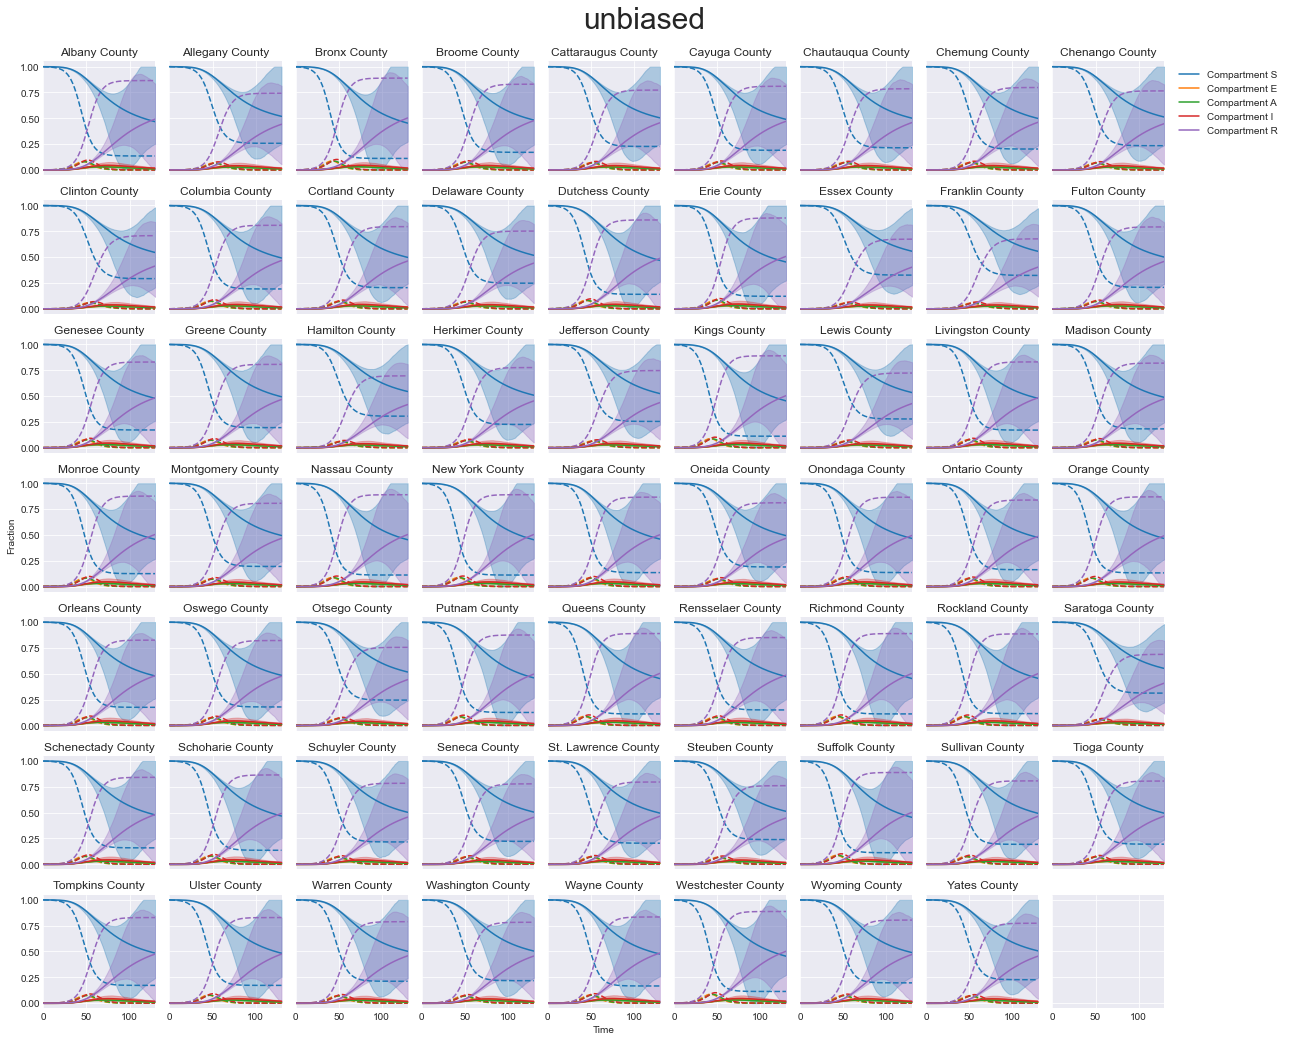

In [104]:
compare_patches(ref_traj,trajs,weights_dict,'unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_unbiased.png',dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


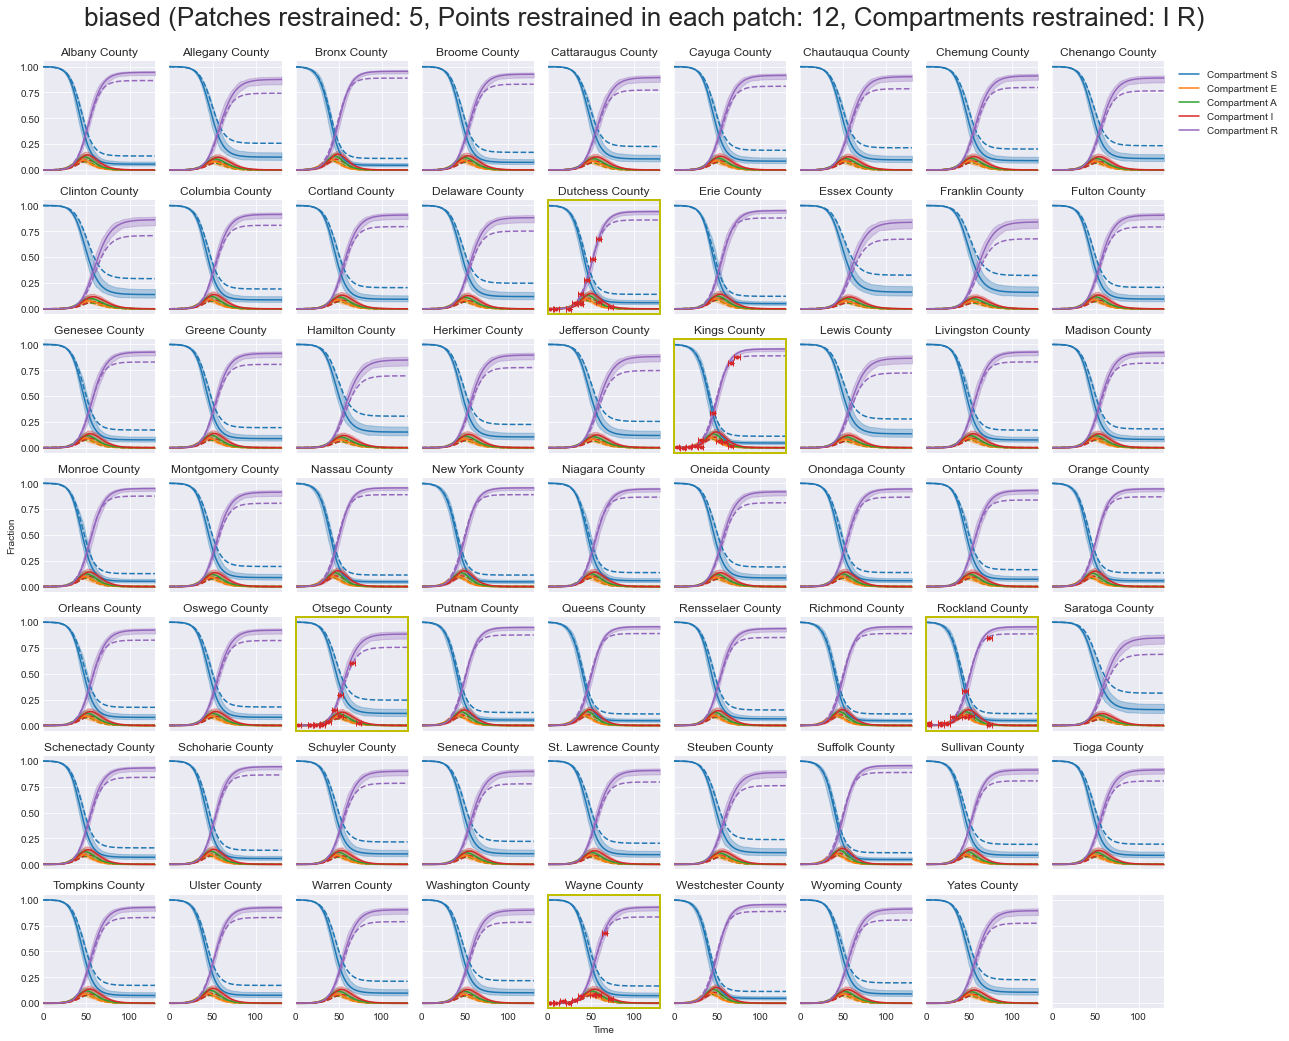

In [105]:
compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_biased_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


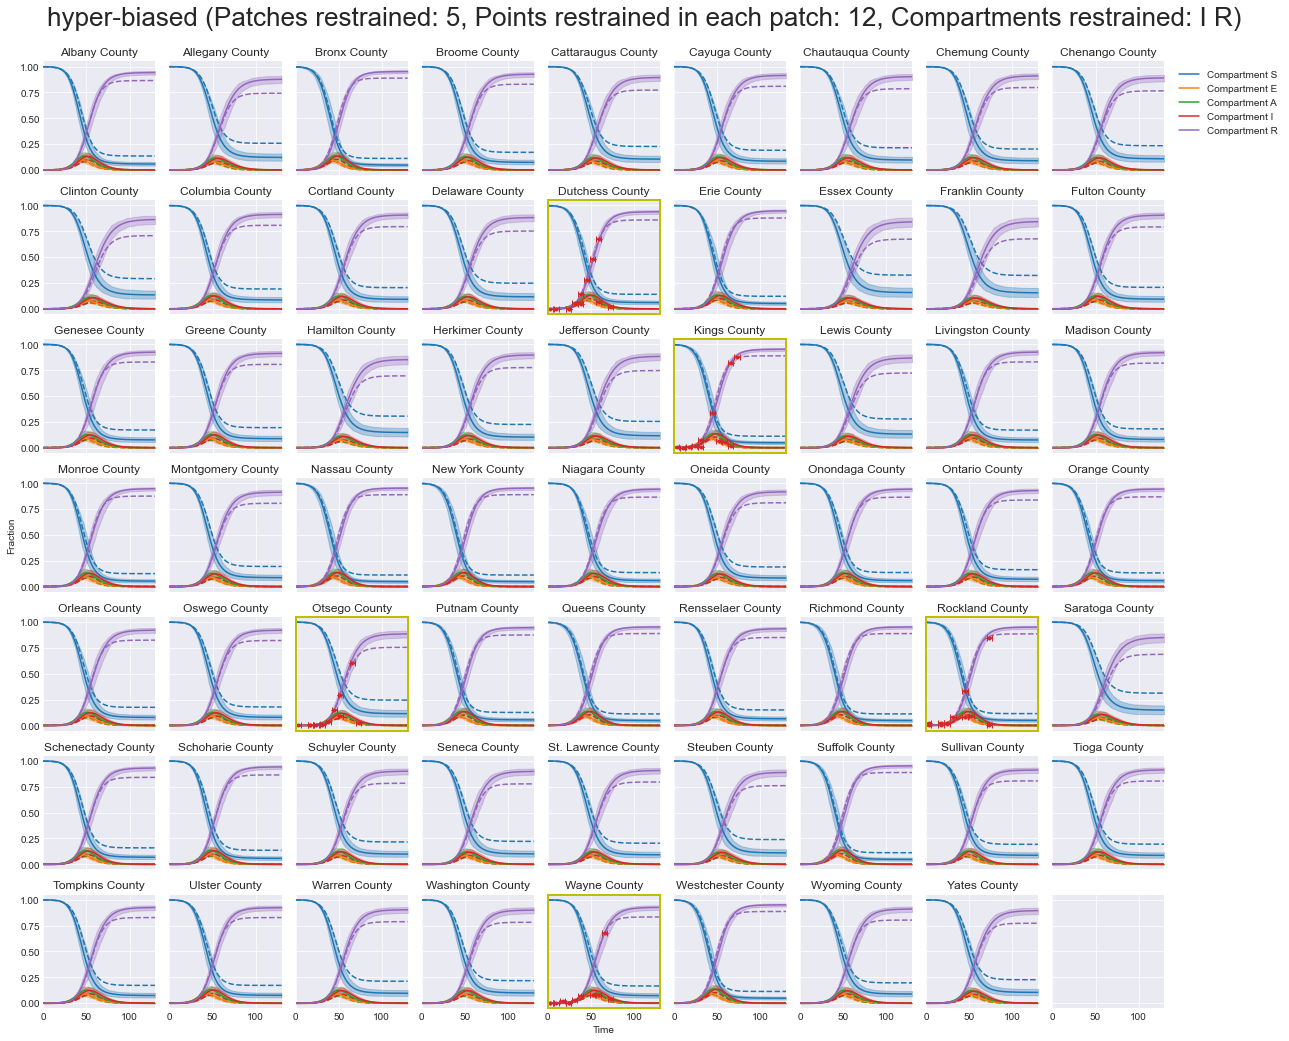

In [106]:
compare_patches(ref_traj,hme_model.trajs,weights_dict,'hyper-biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_hyper_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)

In [107]:
weight_hyper = weights_dict['hyper-biased']
# weight_hyper /=np.sum(weight_hyper)
# mtrajs_patch = np.sum(trajs[:,:,0,:] * weight_hyper[:, np.newaxis, np.newaxis], axis=0)
# print (trajs.shape)
# print (mtrajs_patch.shape)
# print (trajs.shape[2], trajs.shape[-1])
def mean_traj(trajs,weights=None):
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    M = trajs.shape[2]
    if weights is None:
        w = np.ones(trajs.shape[0])
    else:
        w = weights
    w /= np.sum(w)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * w[:, np.newaxis, np.newaxis], axis=0)
    mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return mtrajs

    
mtrajs_hyper_biased = mean_traj(hme_model.trajs,weights = weights_dict['hyper-biased'])



mtrajs_biased = mean_traj(trajs,weights = weights_dict['biased'])
mtrajs_unbiased = mean_traj(trajs)
# REF = ref_traj[p,:,:,:]
# REF = np.expand_dims(REF,axis=0)
mref_traj = mean_traj(ref_traj)


mref_traj = mref_traj[:,:5]

loss_unbiased = np.mean((mref_traj- mtrajs_unbiased)**2)
loss_biased = np.mean((mref_traj- mtrajs_biased)**2)
loss_hyper_biased = np.mean((mref_traj- mtrajs_hyper_biased)**2)



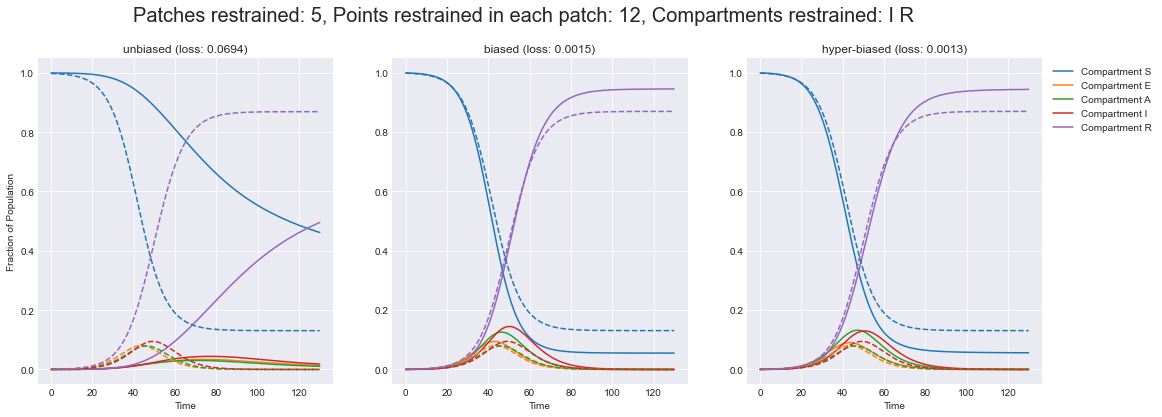

0.9999853308911647


In [108]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {}'
             .format(len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names), fontsize=20,y=1.00)

axs[0].set_title('unbiased (loss: {})'.format(np.round(loss_unbiased,4)))
axs[1].set_title('biased (loss: {})'.format(np.round(loss_biased,4)))
axs[2].set_title('hyper-biased (loss: {})'.format(np.round(loss_hyper_biased,4)))
for i in range(mref_traj.shape[-1]):
    axs[0].plot(range(Time),mtrajs_unbiased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[1].plot(range(Time),mtrajs_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[2].plot(range(Time),mtrajs_hyper_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')

axs[0].plot(mref_traj,linestyle='--')
axs[1].plot(mref_traj,linestyle='--')
axs[2].plot(mref_traj,linestyle='--')
axs[2].legend(bbox_to_anchor=(1.4, 1))
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[0], ylabel='Fraction of Population')

# plt.tight_layout()
plt.savefig('compare_means_restraints_{}{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
plt.show()
print (np.sum(mtrajs_biased[-1]))

In [109]:
Loss = np.mean((mref_traj- mtrajs_unbiased)**2)
print (Loss)

# print(end - start)

0.06940713662538803


Plotting 62 patches in a 7 x 9 grid


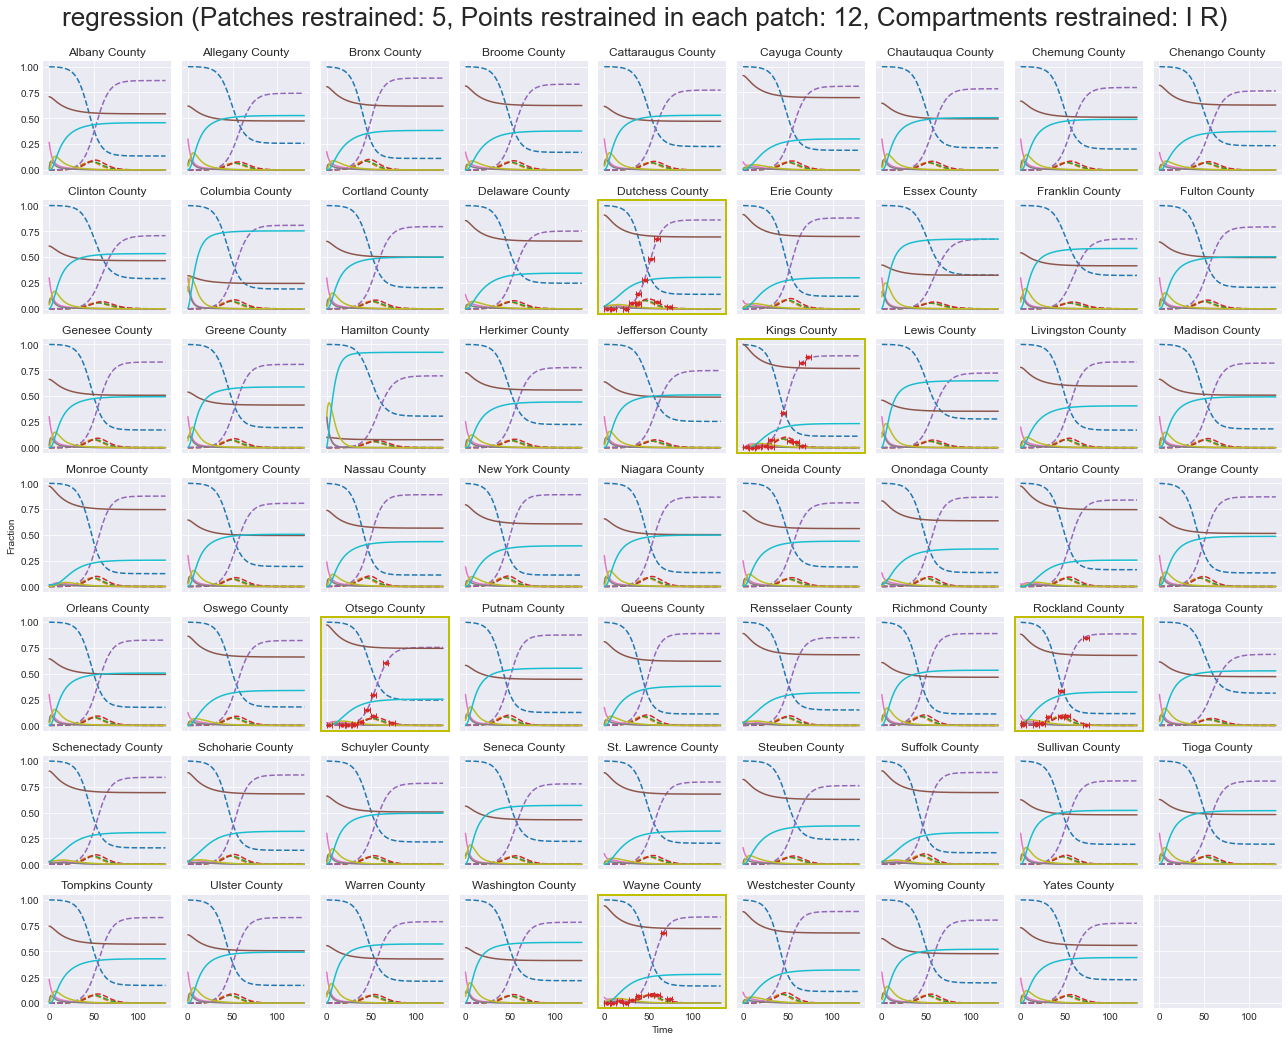

In [110]:
compare_patches(ref_traj,trajs,weights_dict,'regression', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_regression.png',dpi=300)


# Parameter posterior distributions

No handles with labels found to put in legend.


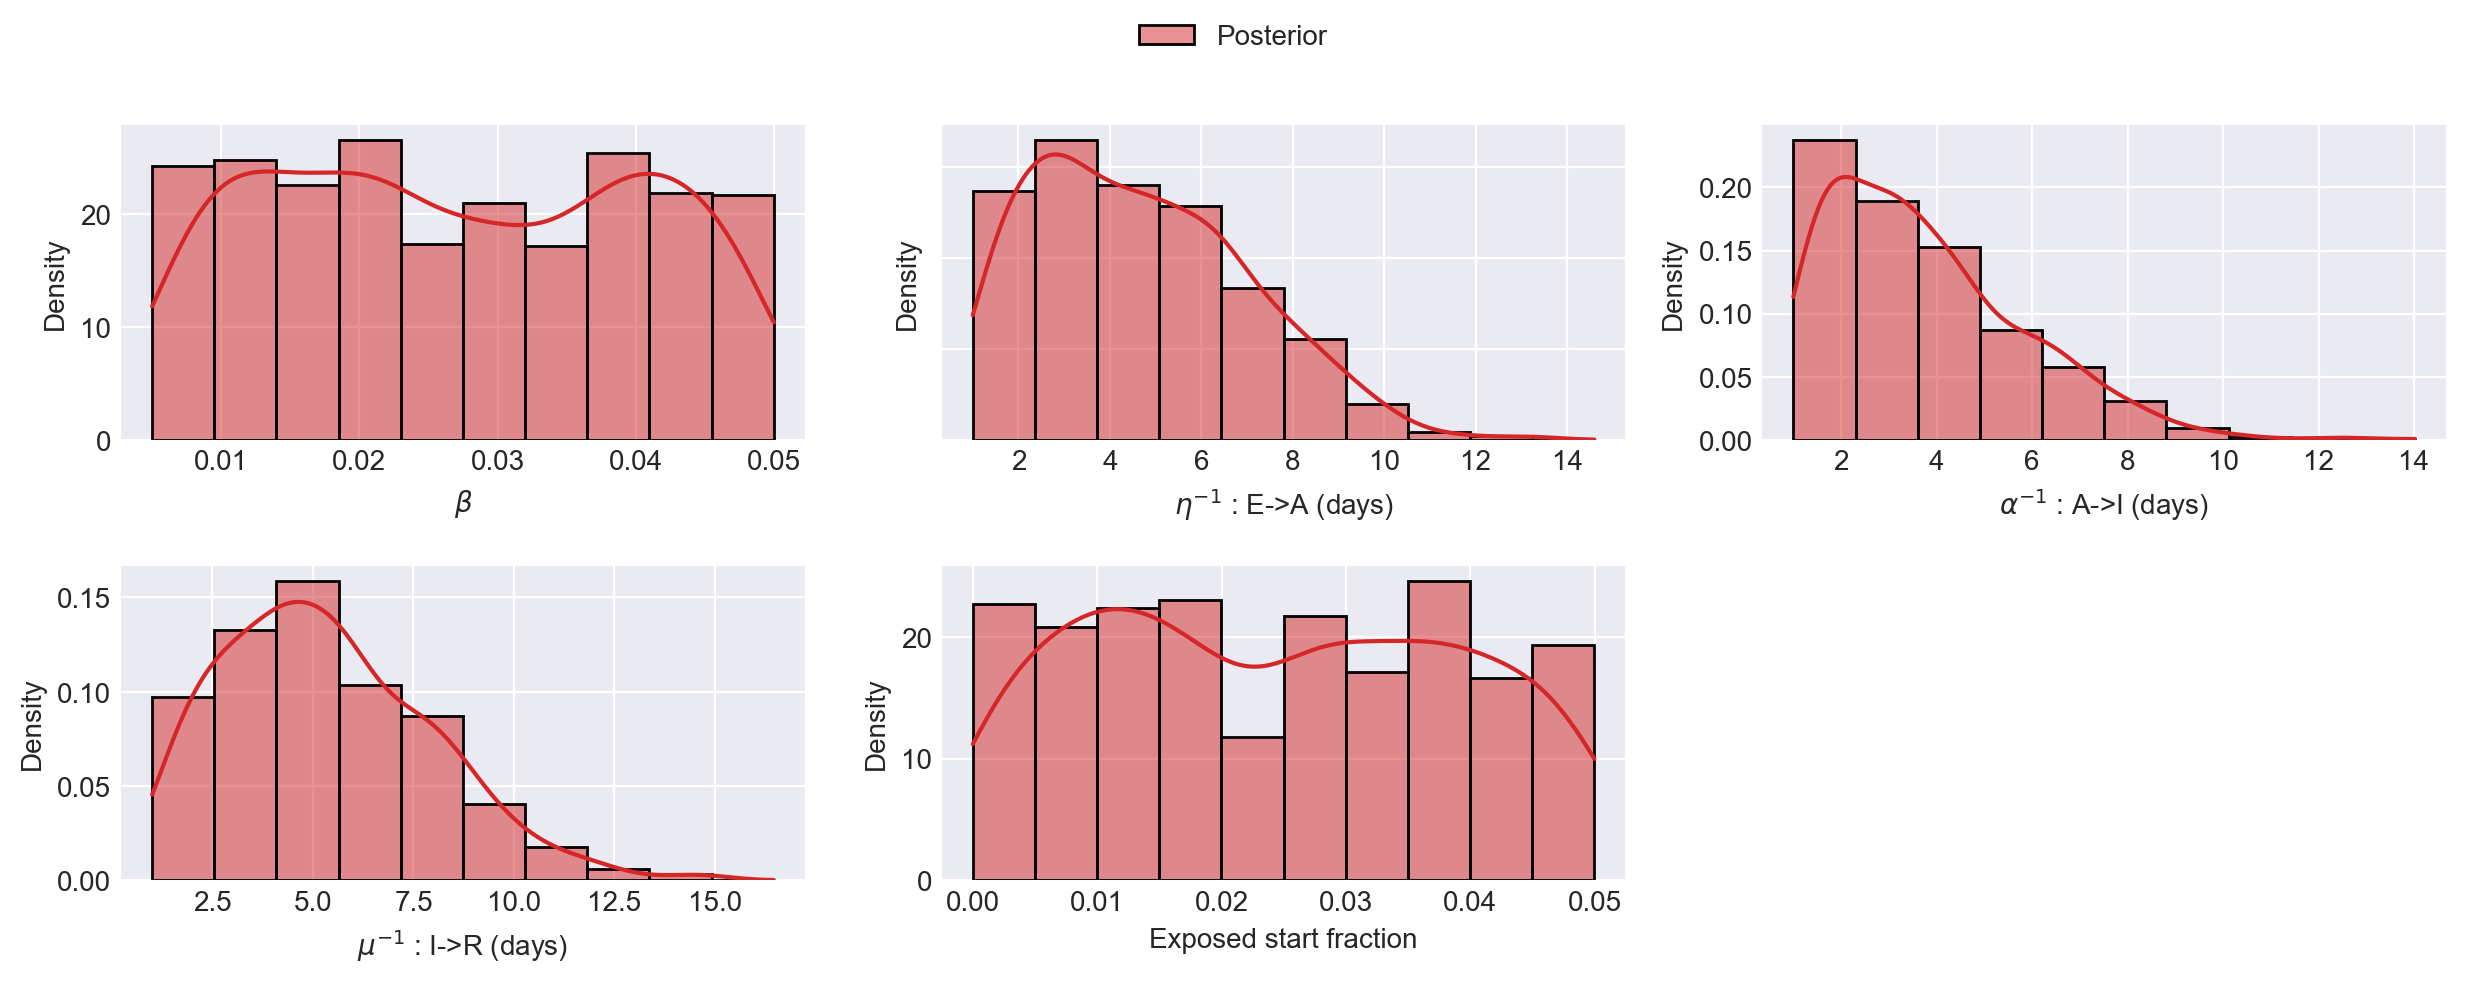

In [111]:

R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist = prior_param_dist
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0], kde=True, stat="density")
axs[0,0].set_xlabel(r'$\beta$')

sns.histplot(x=np.squeeze(E_A), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1], kde=True, stat="density")
axs[0,1].set_xlabel(r'$\eta^{-1}$ : E->A (days)')

sns.histplot(x=np.squeeze(A_I), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2], kde=True, stat="density")
axs[0,2].set_xlabel(r'$\alpha ^{-1}$ : A->I (days)')

sns.histplot(x=np.squeeze(I_R), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0], kde=True, stat="density")
axs[1,0].set_xlabel(r'$\mu^{-1}$ : I->R (days)')

sns.histplot(x=np.squeeze(start_exposed_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1], kde=True, stat="density")
axs[1,1].set_xlabel('Exposed start fraction')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
axs[-1, -1].axis('off')
axs[0,1].set_yticklabels('')
plt.legend()
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)

# Compare posterior with prior

No handles with labels found to put in legend.


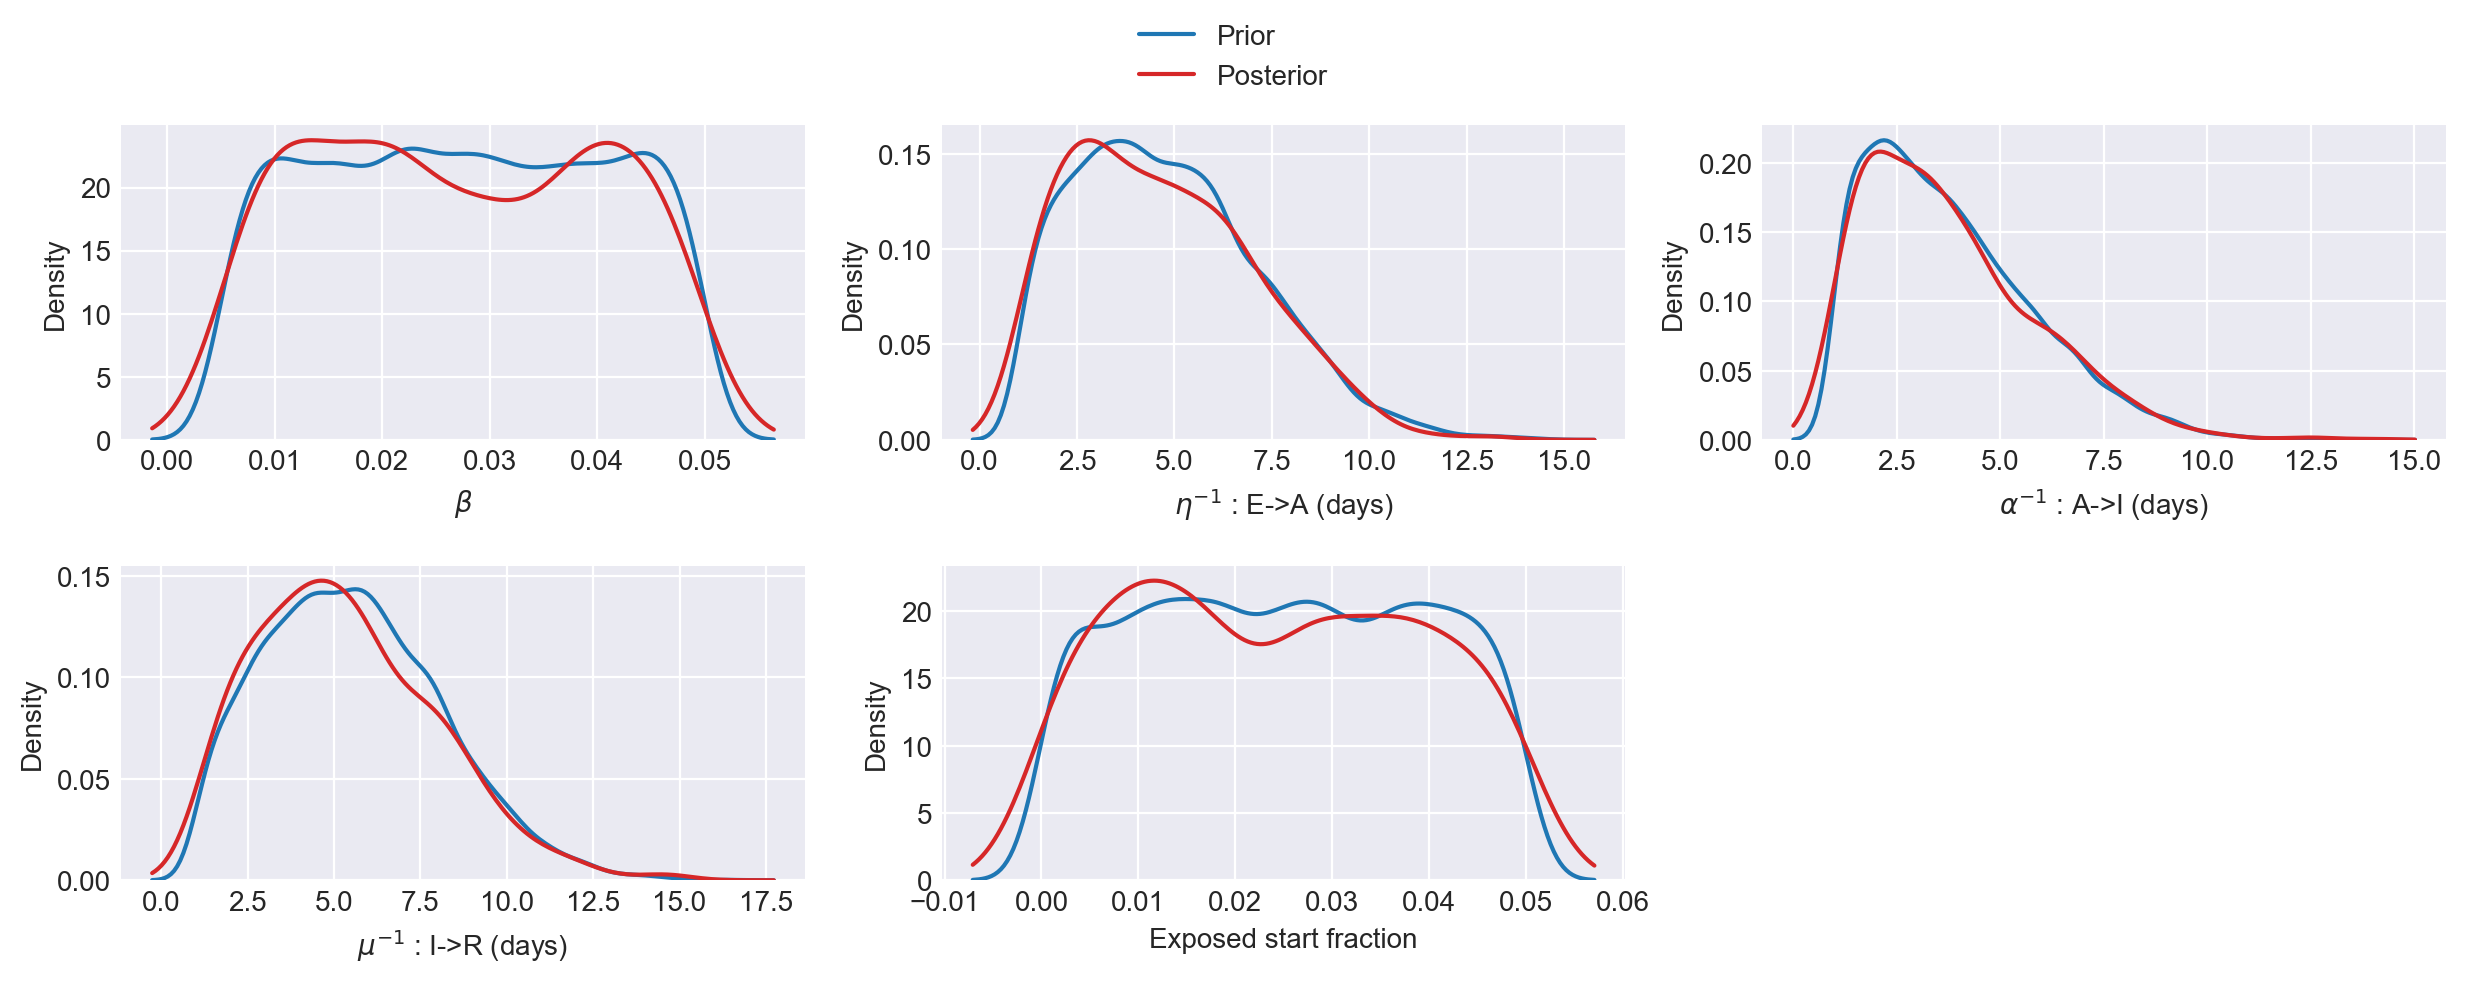

In [112]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta$')
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(E_A), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\eta^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(A_I), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(A_I), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha ^{-1}$ : A->I (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(I_R), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\mu^{-1}$ : I->R (days)')

sns.kdeplot(x=np.squeeze(start_exposed_dist), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(start_exposed_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel('Exposed start fraction')

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
axs[-1, -1].axis('off')
plt.legend()
plt.savefig('compare_param_dist.png', dpi=300)

In [113]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)


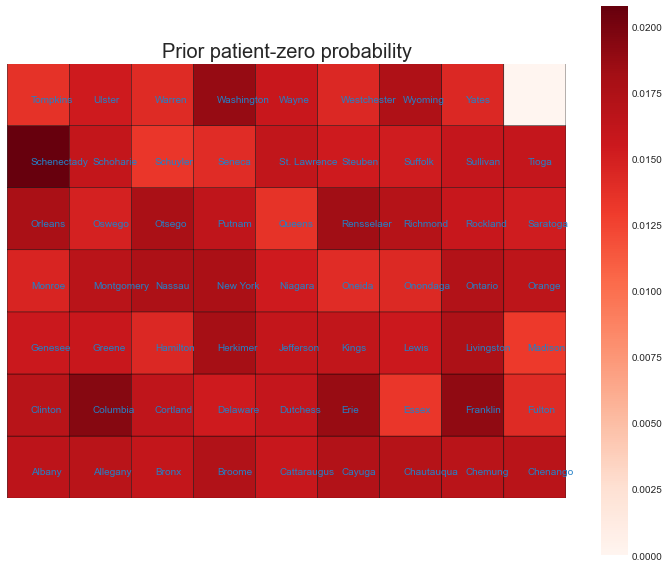

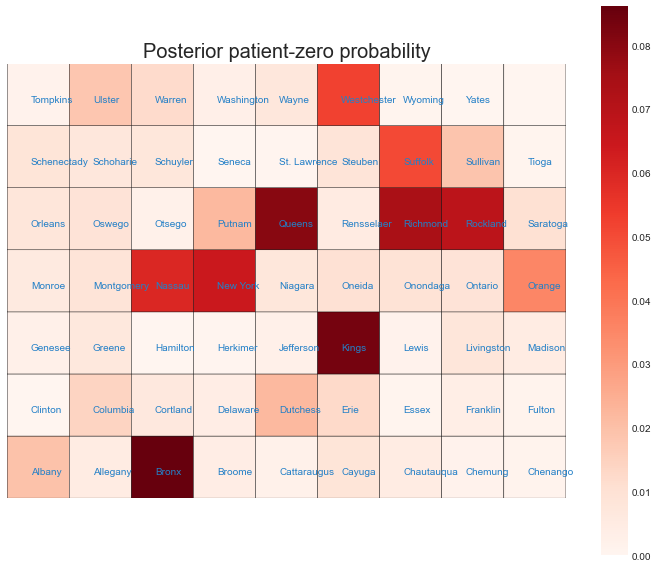

In [114]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=10, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, patch_names=patches, title = 'Posterior patient-zero probability', fontsize=10,figsize=(10,8))

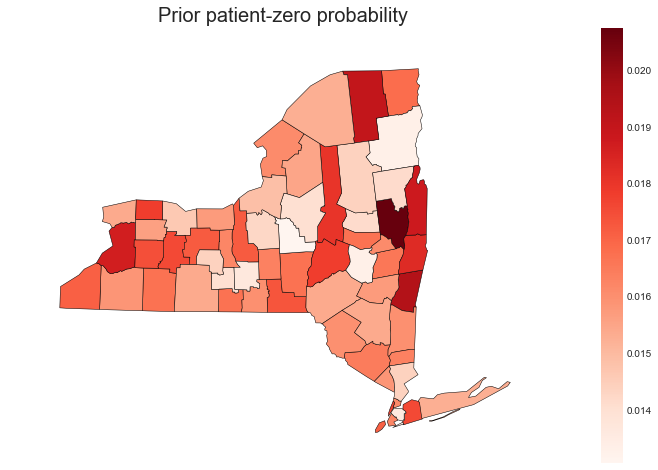

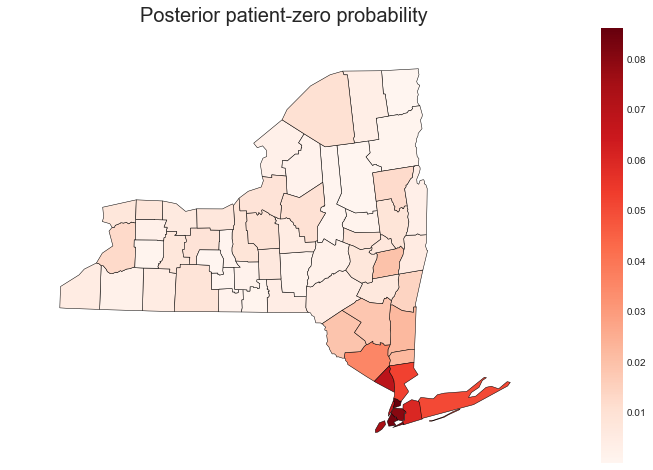

In [115]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

Finding the top 5 most probable locations for the origin of outbreak:

In [116]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.08612195541375886, 'Bronx County'),
 (0.0837447582289776, 'Kings County'),
 (0.08012542257877214, 'Queens County'),
 (0.0738889363412083, 'Richmond County'),
 (0.06928633265259666, 'Rockland County')]

## Theory 1
Basic reproductive number ($R_0$):

$ S \xrightarrow{\beta} E \xrightarrow{\eta} A \xrightarrow{\alpha} I \xrightarrow{\mu} R $

$R_0 = \frac{\beta S_0}{\alpha} +  \frac{\beta S_0}{\mu } $

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [141]:
total_pop = np.sum(population)
R0 = beta*total_pop*(1/alpha + 1/mu)

In [143]:
t_max = np.log(total_pop)/mu/(R0-1)

In [145]:
t_max

1.1706412954888903e-05